In [1]:
import pandas as pd
import gzip
import numpy as np
import csv
import pysam
import os

import scipy

from tqdm.notebook import tqdm

from scipy.io import mmread
from IPython.display import display, display_html, HTML, Markdown

In [2]:
import matplotlib
import matplotlib.pyplot as plt

import bokeh.io as boio
import bokeh.plotting as boplt
import bokeh.layouts as bolay
import bokeh.models as bomod
import bokeh.transform as botrans
import bokeh.palettes as bopal

# Setup any state for libraries or the system:
# Make big figures:
gFIG_SIZE_in = [14, 10]
gPLOT_PARAMS = {
    'legend.fontsize': 'x-large',
    'figure.figsize': gFIG_SIZE_in,
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large'
}
matplotlib.rcParams.update(gPLOT_PARAMS)
plt.rcParams.update(gPLOT_PARAMS)

gBOKEH_SCALE = 80
gFIG_SIZE_px = [gFIG_SIZE_in[0] * gBOKEH_SCALE, gFIG_SIZE_in[1] * gBOKEH_SCALE]
gFONT_SZ_UNITS = "pt"
gTITLE_FONT_SIZE = 36
gAXIS_LABEL_FONT_SIZE = 24
gTICK_LABEL_FONT_SIZE = 16
gTEXT_FONT_SIZE = 16

def fix_matplotlib_plot_visuals(fig, title_size=gTITLE_FONT_SIZE, axis_label_size=gAXIS_LABEL_FONT_SIZE, tick_label_size=gTICK_LABEL_FONT_SIZE, text_size=gTEXT_FONT_SIZE, tight_rect=None):
    """Reformat a matplotlib figure to have good font / legend / label sizes."""

    for ax in fig.get_axes():
        
        for ticklabel in (ax.get_xticklabels()):
            ticklabel.set_fontsize(tick_label_size)
        for ticklabel in (ax.get_yticklabels()):
            ticklabel.set_fontsize(tick_label_size)
        for c in ax.get_children():
            if c.__class__ == matplotlib.text.Text:
                c.set_fontsize(text_size)

        ax.xaxis.get_label().set_fontsize(axis_label_size)
        ax.yaxis.get_label().set_fontsize(axis_label_size)
        ax.title.set_fontsize(title_size)
    
    for c in fig.get_children():
        if c.__class__ == matplotlib.legend.Legend:
            c.prop.set_size(tick_label_size)
            c.get_title().set_size(tick_label_size)
            
    if tight_rect:
        fig.tight_layout(rect=tight_rect)
    else:
        fig.tight_layout()
        
def fix_bokeh_plot_visuals(bokeh_plot):
    bokeh_plot.title.text_font_size = f"{gTITLE_FONT_SIZE}{gFONT_SZ_UNITS}"
    bokeh_plot.title.align = "center"
    
    bokeh_plot.xaxis.axis_label_text_font_size = f"{gAXIS_LABEL_FONT_SIZE}{gFONT_SZ_UNITS}"
    bokeh_plot.xaxis.major_label_text_font_size = f"{gTICK_LABEL_FONT_SIZE}{gFONT_SZ_UNITS}"
    bokeh_plot.xaxis.axis_label_text_color = "black"

    bokeh_plot.yaxis.axis_label_text_font_size = f"{gAXIS_LABEL_FONT_SIZE}{gFONT_SZ_UNITS}"
    bokeh_plot.yaxis.major_label_text_font_size = f"{gTICK_LABEL_FONT_SIZE}{gFONT_SZ_UNITS}"
    bokeh_plot.yaxis.axis_label_text_color = "black"

    # Set autohide to true to only show the toolbar when mouse is over plot
    bokeh_plot.toolbar.autohide = True

def bokeh_turn_off_x_axis(bokeh_plot):
    bokeh_plot.xaxis.axis_line_width = 3
    bokeh_plot.xaxis.axis_line_color = "black"
    bokeh_plot.xaxis.major_tick_line_color = None  # turn off x-axis major ticks
    bokeh_plot.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks
    bokeh_plot.xaxis.major_label_text_font_size = "0pt"  # turn off x-axis tick labels
#     bokeh_plot.y_range.range_padding = 0.0025  # Turn off space around the y direction


In [3]:
def pretty_print_dataframe(df, title=None, rounding_places=2, hide_index=False, raw=False, inline=False):
    def hover(hover_color="#ffff99"):
        return dict(selector="tr:hover",
                    props=[("background-color", "%s" % hover_color)])
    
    table_styles = [
        dict(selector="tr td", props=[("font-size", "12pt")]),
        hover(),
        dict(selector="th", props=[("font-size", "150%"),
                                   ("text-align", "center")])
    ]

    style = df.round(rounding_places).style
    
    if hide_index:
        style = style.hide_index()
    
    if title:
        style = style.set_caption(title)
        
        table_styles.append(
            dict(selector="caption", 
                props=[("text-align", "center"),
                ("font-size", "24pt"),
                ("color", 'black')])
        )
        
    if inline:
        style = style.set_table_attributes("style='display:inline'")
        
    html_string = style.set_table_styles(table_styles).render()
   
    if raw:
        return html_string
    else:
        display(HTML(html_string))

In [4]:
FIG_DIR = "/home/jovyan/work/juffowup/covid-19-aziz/figures_for_paper"
def save_figure(name, fig_dir=FIG_DIR):
#     plt.gca().set_position([0, 0, 1, 1])
    plt.savefig(f"{fig_dir}/{name}.svg")
    plt.savefig(f"{fig_dir}/{name}.png")
    
def save_plotly_figure(fig, name, fig_dir=FIG_DIR):
    fig.write_image(f"{fig_dir}/{name}.svg")
    fig.write_image(f"{fig_dir}/{name}.png")
    
# Make sure we can actually write to FIG_DIR:
os.makedirs(FIG_DIR, exist_ok=True)

In [5]:
# Install fast levenstein distance:
try:
    import editdistance
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install editdistance
    import editdistance

In [6]:
# Define our SIRV sets:

short_isoform_sirvs = ["SIRV101", "SIRV102", "SIRV103", "SIRV105", "SIRV106", "SIRV107", "SIRV109", "SIRV104", "SIRV108", "SIRV110", "SIRV111", "SIRV112", "SIRV201", "SIRV202", "SIRV203", "SIRV204", "SIRV205", "SIRV206", "SIRV207", "SIRV208", "SIRV209", "SIRV301", "SIRV302", "SIRV303", "SIRV304", "SIRV305", "SIRV306", "SIRV307", "SIRV308", "SIRV309", "SIRV310", "SIRV311", "SIRV312", "SIRV313", "SIRV314", "SIRV315", "SIRV403", "SIRV404", "SIRV405", "SIRV406", "SIRV408", "SIRV409", "SIRV410", "SIRV401", "SIRV402", "SIRV407", "SIRV411", "SIRV501", "SIRV502", "SIRV503", "SIRV504", "SIRV505", "SIRV506", "SIRV507", "SIRV508", "SIRV509", "SIRV510", "SIRV511", "SIRV512", "SIRV513", "SIRV514", "SIRV515", "SIRV516", "SIRV517", "SIRV601", "SIRV602", "SIRV603", "SIRV604", "SIRV605", "SIRV606", "SIRV607", "SIRV608", "SIRV609", "SIRV610", "SIRV611", "SIRV612", "SIRV613", "SIRV614", "SIRV615", "SIRV616", "SIRV617", "SIRV618", "SIRV619", "SIRV620", "SIRV621", "SIRV622", "SIRV623", "SIRV624", "SIRV625", "SIRV701", "SIRV702", "SIRV703", "SIRV704", "SIRV705", "SIRV706", "SIRV708", "SIRV707", "SIRV709", "SIRV710", "SIRV711"]
ercc_sirvs = ["ERCC-00130", "ERCC-00004", "ERCC-00136", "ERCC-00108", "ERCC-00116", "ERCC-00092", "ERCC-00095", "ERCC-00131", "ERCC-00062", "ERCC-00019", "ERCC-00144", "ERCC-00170", "ERCC-00154", "ERCC-00085", "ERCC-00028", "ERCC-00033", "ERCC-00134", "ERCC-00147", "ERCC-00097", "ERCC-00156", "ERCC-00123", "ERCC-00017", "ERCC-00083", "ERCC-00096", "ERCC-00171", "ERCC-00009", "ERCC-00042", "ERCC-00060", "ERCC-00035", "ERCC-00025", "ERCC-00051", "ERCC-00053", "ERCC-00148", "ERCC-00126", "ERCC-00034", "ERCC-00150", "ERCC-00067", "ERCC-00031", "ERCC-00109", "ERCC-00073", "ERCC-00158", "ERCC-00104", "ERCC-00142", "ERCC-00138", "ERCC-00117", "ERCC-00075", "ERCC-00074", "ERCC-00113", "ERCC-00145", "ERCC-00111", "ERCC-00076", "ERCC-00044", "ERCC-00162", "ERCC-00071", "ERCC-00084", "ERCC-00099", "ERCC-00054", "ERCC-00157", "ERCC-00143", "ERCC-00039", "ERCC-00058", "ERCC-00120", "ERCC-00040", "ERCC-00164", "ERCC-00024", "ERCC-00016", "ERCC-00012", "ERCC-00098", "ERCC-00057", "ERCC-00002", "ERCC-00046", "ERCC-00003", "ERCC-00043", "ERCC-00022", "ERCC-00112", "ERCC-00165", "ERCC-00079", "ERCC-00078", "ERCC-00163", "ERCC-00059", "ERCC-00160", "ERCC-00014", "ERCC-00077", "ERCC-00069", "ERCC-00137", "ERCC-00013", "ERCC-00168", "ERCC-00041", "ERCC-00081", "ERCC-00086", "ERCC-00061", "ERCC-00048"]
long_sirvs = ["SIRV4001", "SIRV4002", "SIRV4003", "SIRV6001", "SIRV6002", "SIRV6003", "SIRV8001", "SIRV8002", "SIRV8003", "SIRV10001", "SIRV10002", "SIRV10003", "SIRV12001", "SIRV12002", "SIRV12003"]

short_isoform_sirv_set = set(short_isoform_sirvs)
ercc_sirv_set = set(ercc_sirvs)
long_sirv_set = set(long_sirvs)

in_silico_sirv_set = {"SIRV104", "SIRV110", "SIRV111", "SIRV112", "SIRV207", "SIRV208", "SIRV209", "SIRV312", "SIRV313", "SIRV314", "SIRV315", "SIRV401", "SIRV402", "SIRV407", "SIRV411", "SIRV513", "SIRV514", "SIRV515", "SIRV516", "SIRV517", "SIRV619", "SIRV620", "SIRV621", "SIRV622", "SIRV623", "SIRV624", "SIRV625", "SIRV708", "SIRV709", "SIRV710", "SIRV711"}
alt_in_silico_sirv_set = {"SIRV106", "SIRV107", "SIRV108", "SIRV109", "SIRV104", "SIRV110", "SIRV111", "SIRV112", "SIRV205", "SIRV206", "SIRV307", "SIRV308", "SIRV309", "SIRV310", "SIRV311", "SIRV312", "SIRV313", "SIRV314", "SIRV315", "SIRV408", "SIRV409", "SIRV410", "SIRV401", "SIRV402", "SIRV407", "SIRV411", "SIRV511", "SIRV512", "SIRV513", "SIRV514", "SIRV515", "SIRV516", "SIRV517", "SIRV616", "SIRV617", "SIRV618", "SIRV619", "SIRV620", "SIRV621", "SIRV622", "SIRV623", "SIRV624", "SIRV625", "SIRV707", "SIRV708", "SIRV709", "SIRV710", "SIRV711"}

real_sirv_isoform_list = [s for s in short_isoform_sirvs if s not in in_silico_sirv_set]

In [7]:
# Functions for creating our confusion matrix:

import time
import pickle

def get_num_reads(bam_file_name):
    """Get the number of reads from an indexed bam file."""
    try:
        tot = 0
        for line in pysam.idxstats(bam_file_name, catch_stdout=True, split_lines=True):
            elements = line.split("\t")
            count_idx = 3 if elements[0] == "*" else 2
            tot += int(elements[count_idx])
    except:
        tot=None
    return tot

def create_confusion_matrix(bam_file_name, tx_name_map, is_gencode=False, in_silico_sirv_set=None, do_cleanup_checkpoints=False):
    """Create a confusion matrix for the given bam file, replacing names with those in the given tx_name_map.
    
    @return: A dataframe object containing our confusion matrix.
    
    NOTE: this assumes that each read in the given bam file is aligned to a transcriptome, not the genome"""
    
    print(f"Creating confusion matrix from file: {bam_file_name}")
    
    REBUILD_IT = False
    
    confusion_matrix_filename = os.path.splitext(os.path.basename(bam_file_name))[0] + ".confusion_matrix.pickle"
    if (not REBUILD_IT) and os.path.exists(confusion_matrix_filename):
        print(f"Loading confusion matrix from Pickle ({os.path.abspath(confusion_matrix_filename)})...")
        confusion_matrix_df = pickle.load(open(confusion_matrix_filename, "rb"))
        print("Done!")
    else:
        print(f"Generating confusion matrix.")
        # Create some checkpoint files along the way to save time:
        chkpt_name_read_name_contig_dict = os.path.splitext(os.path.basename(bam_file_name))[0] + ".read_name_contig_dict.pickle"
        chkpt_name_raw_conf_matrix = os.path.splitext(os.path.basename(bam_file_name))[0] + ".raw_conf_matrix.pickle"
        chkpt_name_normalized_conf_matrix = os.path.splitext(os.path.basename(bam_file_name))[0] + ".normalized_conf_matrix.pickle"
        
        # Get our transcript names:
        tx_names = tx_name_map.values()

        # Setup variables for edit distance counts:
        mat_index_dict = {s: i for i,s in enumerate(tx_names)}
        # We shouldn't have a very full confusion matrix, so we can use a sparse matrix here to save memory:
        confusion_matrix = scipy.sparse.lil_matrix((len(tx_names), len(tx_names)), dtype=np.float64)

        num_unmapped_reads = 0
        num_unambiguous_alignments = 0
        num_ambiguous_alignments = 0
        num_ambiguously_aligned_reads = 0 
        num_mq0_reads = 0
        num_secondary_reads = 0
        num_supplementary_reads = 0
        
        # Get the number of reads in the bam file for our progress bar:
        num_reads_in_bamfile = get_num_reads(bam_file_name)

        # Create a map of each read to the contig to which it is aligned:
        # We will use this as the basis for our confusion matrix:
        # NOTE: We ignore non-primary alignments, unmapped reads, and reads with MQ=0
        st = time.time()
        if (not REBUILD_IT) and os.path.exists(chkpt_name_raw_conf_matrix):
            # Skip checkpoint if the next dataset is there.
            print("Skipping checkpoint - next checkpoint exists.")
            pass
        elif (not REBUILD_IT) and os.path.exists(chkpt_name_read_name_contig_dict):
            print(f"Loading checkpoint data: ({chkpt_name_read_name_contig_dict})...")
            read_name_contig_dict = pickle.load(open(chkpt_name_read_name_contig_dict, "rb"))
            print("Done!")
        else:
            with pysam.AlignmentFile(bam_file_name, "rb", check_sq=False, require_index=False) as bam_file, tqdm(desc="Processing Reads", unit="read", total=num_reads_in_bamfile) as pbar:
                read_name_contig_dict = dict()
                for read in bam_file:
                    if read.is_unmapped:
                        num_unmapped_reads += 1
                        pbar.update(1)
                        continue
                        
                    # Transform the name into one that is shorter / readable
                    if is_gencode:
                        # For gencode, TX names are VERY long and of the form:
                        # ENST00000641515.2|ENSG00000186092.6|OTTHUMG00000001094.4|OTTHUMT00000003223.4|OR4F5-202|OR4F5|2618|UTR5:1-60|CDS:61-1041|UTR3:1042-2618|
                        # 
                        # for this we only need to grab the part up to the first pipe:
                        contig_name = tx_name_map[read.reference_name[:read.reference_name.find("|")]]
                    else:
                        contig_name = tx_name_map[read.reference_name]
                        
                    # Just warn the user here.  Right now we don't have to filter.
                    # We do that next.
                    if in_silico_sirv_set and (contig_name in in_silico_sirv_set):
                        if (not read.is_secondary) and (not read.is_supplementary):
                            # this is a primary in-silico SIRV alignment.
                            print(f"Read {read.query_name}: primary alignment to: {contig_name}", file=sys.stderr)
                        
                    if read.mapping_quality == 0:
                        num_mq0_reads += 1
                    else:
                        try:
                            read_name_contig_dict[read.query_name].append(contig_name)
                        except KeyError:
                            read_name_contig_dict[read.query_name] = [contig_name]
                    pbar.update(1)
        
            print("Pickling checkpoint data...", end="\t")
            pickle.dump(read_name_contig_dict, open(chkpt_name_read_name_contig_dict, "wb"))
            print("done!")
        
        # Now go through each read and tally the alignment counts
        # if it is aligned to multiple transcripts then we must adjust our weight across all those transcripts
        if (not REBUILD_IT) and os.path.exists(chkpt_name_raw_conf_matrix):
            print(f"Loading checkpoint data: ({chkpt_name_raw_conf_matrix})...")
            confusion_matrix = pickle.load(open(chkpt_name_raw_conf_matrix, "rb"))
            print("Done!")
        else:
            with tqdm(desc="Tallying Alignments", unit="read", total=len(read_name_contig_dict.keys())) as pbar:
                for read_name, aligned_contig_list in read_name_contig_dict.items():
                    if len(aligned_contig_list) == 1:
                        
                        # Ignore the contigs in our in-silico set, if requested:
                        if in_silico_sirv_set and (aligned_contig_list[0] in in_silico_sirv_set):
                            pbar.update(1)
                            continue
                        
                        si = mat_index_dict[aligned_contig_list[0]]
                        if confusion_matrix[si, si] == 0:
                            confusion_matrix[si, si] = 1
                        else:
                            confusion_matrix[si, si] += 1
                        num_unambiguous_alignments += 1
                    else:
                        
                        # Ignore the contigs in our in-silico set, if requested:
                        if in_silico_sirv_set and (aligned_contig_list[0] in in_silico_sirv_set):
                            pbar.update(1)
                            continue
                        
                        num_ambiguously_aligned_reads += 1
                        num_ambiguous_alignments += len(aligned_contig_list)

                        # Per conversation with Mehrtash:
                        # Spread out the total weight (1) across the possible alignments:
                        step = 1/(len(aligned_contig_list) * len(aligned_contig_list))

                        for a in aligned_contig_list:
                            for b in aligned_contig_list:
                                s1_i = mat_index_dict[a]
                                s2_i = mat_index_dict[b]

                                if confusion_matrix[s1_i, s2_i] == 0:
                                    confusion_matrix[s1_i, s2_i] = step
                                else:
                                    confusion_matrix[s1_i, s2_i] += step
                    pbar.update(1)

            print("Pickling checkpoint data...", end="\t")
            pickle.dump(confusion_matrix, open(chkpt_name_raw_conf_matrix, "wb"))
            print("done!")

        # Normalize our counts to produce an effective probability for each transcript.
        # The matrix we have now is symmetrical, so we can arbitrarily choose a dimension across which to normalize.
        # Here we choose columns:
        if (not REBUILD_IT) and os.path.exists(chkpt_name_normalized_conf_matrix):
            print(f"Loading checkpoint data: ({chkpt_name_normalized_conf_matrix})...")
            confusion_matrix = pickle.load(open(chkpt_name_normalized_conf_matrix, "rb"))
            print("Done!")
        else:
            with tqdm(desc="Normalizing columns", unit="column", total=confusion_matrix.shape[0]) as pbar:
                # Note the extra index here.
                # This is needed because of how sum on sparse matrices works:
                confusion_matrix = confusion_matrix.tocsc()
                sums = confusion_matrix.sum(axis=0)
                for col_i in range(confusion_matrix.shape[0]):
                    if sums[0, col_i] != 0:
                        confusion_matrix[:, col_i] = confusion_matrix[:, col_i] / sums[0, col_i]
                    pbar.update(1)

            print("Pickling checkpoint data...", end="\t")
            pickle.dump(confusion_matrix, open(chkpt_name_normalized_conf_matrix, "wb"))
            print("done!")

        # Make it into a DataFrame:
        confusion_matrix_df = pd.DataFrame.sparse.from_spmatrix(data=confusion_matrix, index=mat_index_dict.keys(), columns=mat_index_dict.keys())

        et = time.time()
        print()
        print(f"Done!  (elapsed time: {et - st:2.3f})")

        # Save our work for next time:
        print("Pickling data...")
        pickle.dump(confusion_matrix_df, open(confusion_matrix_filename, "wb"))

        print(f"Num Reads: {len(read_name_contig_dict.keys())}")
        print(f"Num Unambiguous Alignments: {num_unambiguous_alignments}")
        print(f"Num Ambiguously Aligned Reads: {num_ambiguously_aligned_reads}")
        print(f"Num Ambiguous Alignments: {num_ambiguous_alignments}")
        print(f"Num Unmapped Reads: {num_unmapped_reads}")
        print(f"Num MQ0 Reads: {num_mq0_reads}")
        print(f"Num Secondary Reads: {num_secondary_reads}")
        print(f"Num Supplementary Reads: {num_supplementary_reads}")
        
        if do_cleanup_checkpoints:
            for f in [chkpt_name_read_name_contig_dict, chkpt_name_raw_conf_matrix, chkpt_name_normalized_conf_matrix]:
                if os.path.exists(f):
                    os.remove(f)
        
    return confusion_matrix_df

def plot_sparse_with_colors(M, cmap="jet", threshold=None):
    """Plot a sparse matrix with a given colormap.
    For REALLY large data, this is essentially required."""
    ax = plt.gca()
    x, y, v = scipy.sparse.find(M)
    if threshold:
        h = ax.scatter(x[v>=threshold], y[v>=threshold], c=v[v>=threshold], s=3, cmap=cmap)
    else:
        h = ax.scatter(x, y, c=v, s=3, cmap=cmap)
        
    cb = plt.colorbar(h, ax=ax) 
    cb.ax.tick_params(labelsize=14)
    
    ax.set_xlim(0, M.shape[0])
    ax.set_ylim(0, M.shape[1])

def plot_confusion_matrix(conf_mat_df, indices_to_plot=None, dataset_name="", vmax=0.1):
    """Create a plot of the given confusion matrix over the given indices.
    
    If no indices are given, then will plot all points in the given dataframe.
    """
    if indices_to_plot is None:
        indices_to_plot = np.full(len(conf_mat_df.index.values), fill_value=True, dtype=np.bool)
    
    fig = plt.figure(figsize=[i*5 for i in gFIG_SIZE_in], facecolor='w')
    ax = fig.add_subplot()
    
    cols_to_plot = conf_mat_df.columns[indices_to_plot]
    plt.pcolor(conf_mat_df[cols_to_plot][indices_to_plot], cmap=plt.get_cmap("Blues"), vmax=vmax)

#     sparse_mat = conf_mat_df.sparse.to_coo().tolil()
#     plot_sparse_with_colors(sparse_mat[indices_to_plot, indices_to_plot], cmap=plt.get_cmap("Blues"))
    
    plt.yticks(np.arange(0.5, len(conf_mat_df.index[indices_to_plot]), 1), conf_mat_df.index[indices_to_plot])
    plt.xticks(np.arange(0.5, len(conf_mat_df.columns[indices_to_plot]), 1), conf_mat_df.columns[indices_to_plot])
    ax.set_xticklabels(conf_mat_df.columns[indices_to_plot], rotation=90)
    plt.gca().invert_yaxis()  # Make it like Mehrtash's plot
    
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    
    ax.set_title(f'{dataset_name} Confusion Matrix');
    
    fix_matplotlib_plot_visuals(fig, gTITLE_FONT_SIZE, gTITLE_FONT_SIZE, gTICK_LABEL_FONT_SIZE)
    fig.show()
    
def get_sirv_name_map(sirv_file="SIRV_Set_4.tsv", in_silico_exclusion_set=None):
    """Creates a sirv_name -> sirv_name map from the given SIRV table."""
    print("Creating SIRV name map...", end="\t")
    sirv_name_map = dict()
    with open(sirv_file, "r") as f:
        tsv_file = csv.reader(f, delimiter="\t")
        next(tsv_file)
        for row in tsv_file:
            if in_silico_exclusion_set and (row[0] in in_silico_exclusion_set):
                continue
            sirv_name_map[row[0]] = row[0]
            
    print("Done!")
    
    return sirv_name_map

def get_conf_mat_scores(conf_mat_df, sirv_indices):
    """Get the overall score and the per-SIRV scores for the given dataframe."""
    
    # Get the boundaries for each sirv gene:
    sirv_gene_index_dict = dict()
    start_indx = 0
    last_sirv = conf_mat_df.index.values[sirv_indices][0][:5]
    for i, sirv_name in enumerate(conf_mat_df.index.values[sirv_indices]):
        cur_sirv = sirv_name[:5]
        if cur_sirv != last_sirv:
            sirv_gene_index_dict[last_sirv] = (start_indx, i)
            last_sirv = cur_sirv
            start_indx = i
    sirv_gene_index_dict[last_sirv] = (start_indx, i)
    
    # Subset the dataframe to the indices to consider:
    cols = conf_mat_df.columns[sirv_indices]
    count_matrix = conf_mat_df[cols][sirv_indices].to_numpy()

    # Now get the scores: 
    
    # Overall score:
    good_total = np.sum([count_matrix[i,i] for i in range(len(count_matrix))])
    bad_total = np.sum(count_matrix) - good_total
    overall_score = good_total / (bad_total + good_total)
    
    # Per-SIRV Gene Score:
    sirv_gene_score_dict = {"Overall": overall_score}
    for sirv_gene, (start_index, end_index) in sirv_gene_index_dict.items():
        good_total = np.sum([count_matrix[i,i] for i in range(start_index, end_index)])
        bad_total = np.sum(count_matrix[:, start_index:end_index]) - good_total
        
        sirv_gene_score_dict[sirv_gene] = good_total / (bad_total + good_total)
    
    return sirv_gene_score_dict

In [8]:
in_silico_exclusion_set = None
# in_silico_exclusion_set = in_silico_sirv_set

sirv_set_4_tsv_file = "/home/jovyan/work/juffowup/covid-19-aziz/metrics2/SIRV_Set_4.tsv"
sirv_name_map = get_sirv_name_map(sirv_set_4_tsv_file)

# Read in SIRV sequences:
sirv_set_4_names = list()
with open(sirv_set_4_tsv_file, "r") as f:
    sirv_set_4_tsv = csv.reader(f, delimiter="\t")
    next(sirv_set_4_tsv)
    for row in sirv_set_4_tsv:
        if in_silico_exclusion_set and (row[0] in in_silico_exclusion_set):
            continue
        sirv_set_4_names.append(row[0])

sirv_mat_index_dict = {s: i for i,s in enumerate(sirv_set_4_names)}

Creating SIRV name map...	Done!


In [9]:
VMAX = 0.1

Creating confusion matrix from file: /home/jovyan/work/juffowup/covid-19-aziz/SIRV_Data/m64218e_210513_071714.isoseq_sirvs.sirv_aligned.bam
Loading confusion matrix from Pickle (/home/jovyan/work/juffowup/covid-19-aziz/metrics2/m64218e_210513_071714.isoseq_sirvs.sirv_aligned.confusion_matrix.pickle)...
Done!

IsoSeq3 Scores:
Overall	0.9834168971109415
SIRV1	0.9532715279397387
SIRV2	0.9716688916289488
SIRV3	0.9894988139972166
SIRV4	0.9886605325082107
SIRV5	0.9826634688159416
SIRV6	0.9890255838939331
SIRV7	0.9992374704154323


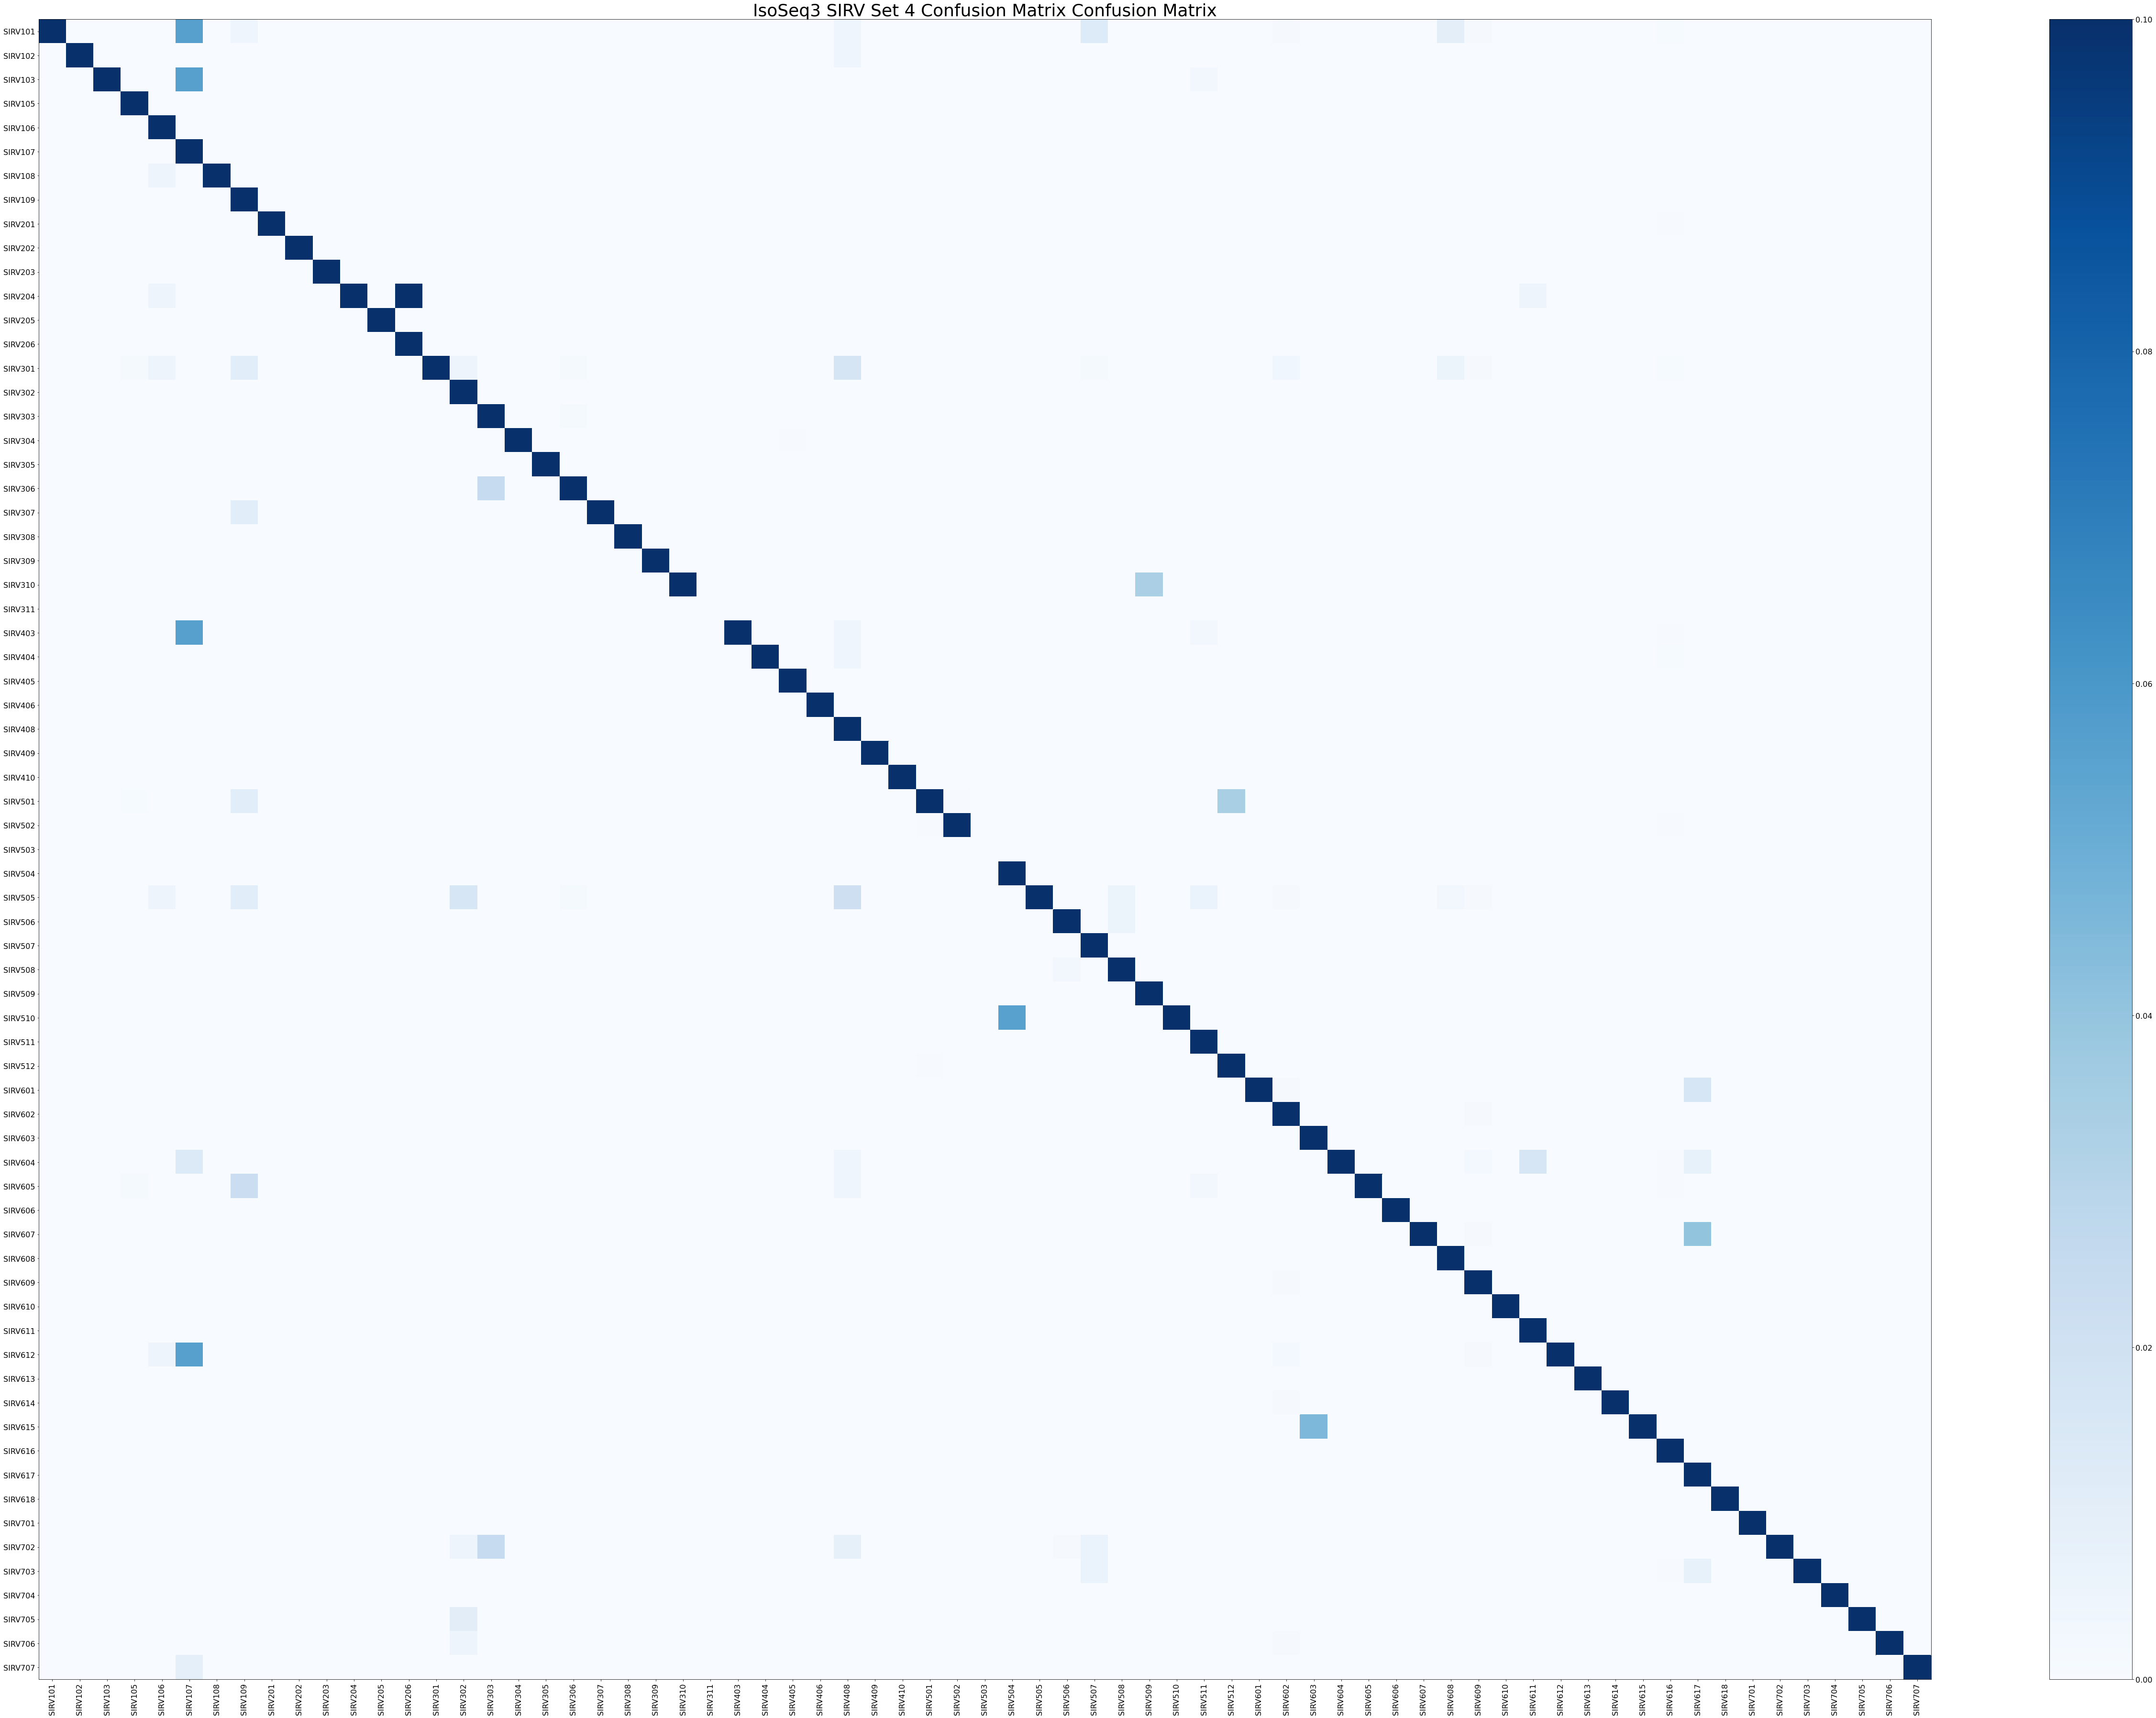

In [10]:
# Iso Seq SIRVs:
iso_sirv_sample_bam = "/home/jovyan/work/juffowup/covid-19-aziz/SIRV_Data/m64218e_210513_071714.isoseq_sirvs.sirv_aligned.bam"

iso_sirv_conf_mat_df = create_confusion_matrix(iso_sirv_sample_bam, sirv_name_map, in_silico_sirv_set=in_silico_exclusion_set) 
si_sirv_indx = np.isin(iso_sirv_conf_mat_df.index.values, list(real_sirv_isoform_list))
plot_confusion_matrix(iso_sirv_conf_mat_df, si_sirv_indx, dataset_name=f"IsoSeq3 SIRV Set 4 Confusion Matrix", vmax=VMAX)

save_figure(f"1Fa_IsoSeq3_SIRV_Confusion_Matrix")

sirv_gene_score_dict = get_conf_mat_scores(iso_sirv_conf_mat_df, si_sirv_indx)
print()
print(f"IsoSeq3 Scores:")
for k, v in sirv_gene_score_dict.items():
    print(f"{k}\t{v}")

# We're going to need to clean up some memory here:
del iso_sirv_conf_mat_df, si_sirv_indx

Creating confusion matrix from file: /home/jovyan/work/juffowup/covid-19-aziz/SIRV_Data/CDH222_SIRV_MAS_15_array_elements_longbow_extracted_tx_aligned.bam
Loading confusion matrix from Pickle (/home/jovyan/work/juffowup/covid-19-aziz/metrics2/CDH222_SIRV_MAS_15_array_elements_longbow_extracted_tx_aligned.confusion_matrix.pickle)...
Done!

MAS-seq 15x Scores:
Overall	0.9952067832647438
SIRV1	0.9956069314094707
SIRV2	0.9969210104072498
SIRV3	0.9920582806633567
SIRV4	0.9980483896260477
SIRV5	0.9904755868526538
SIRV6	0.9973709066520282
SIRV7	0.9975201421041082


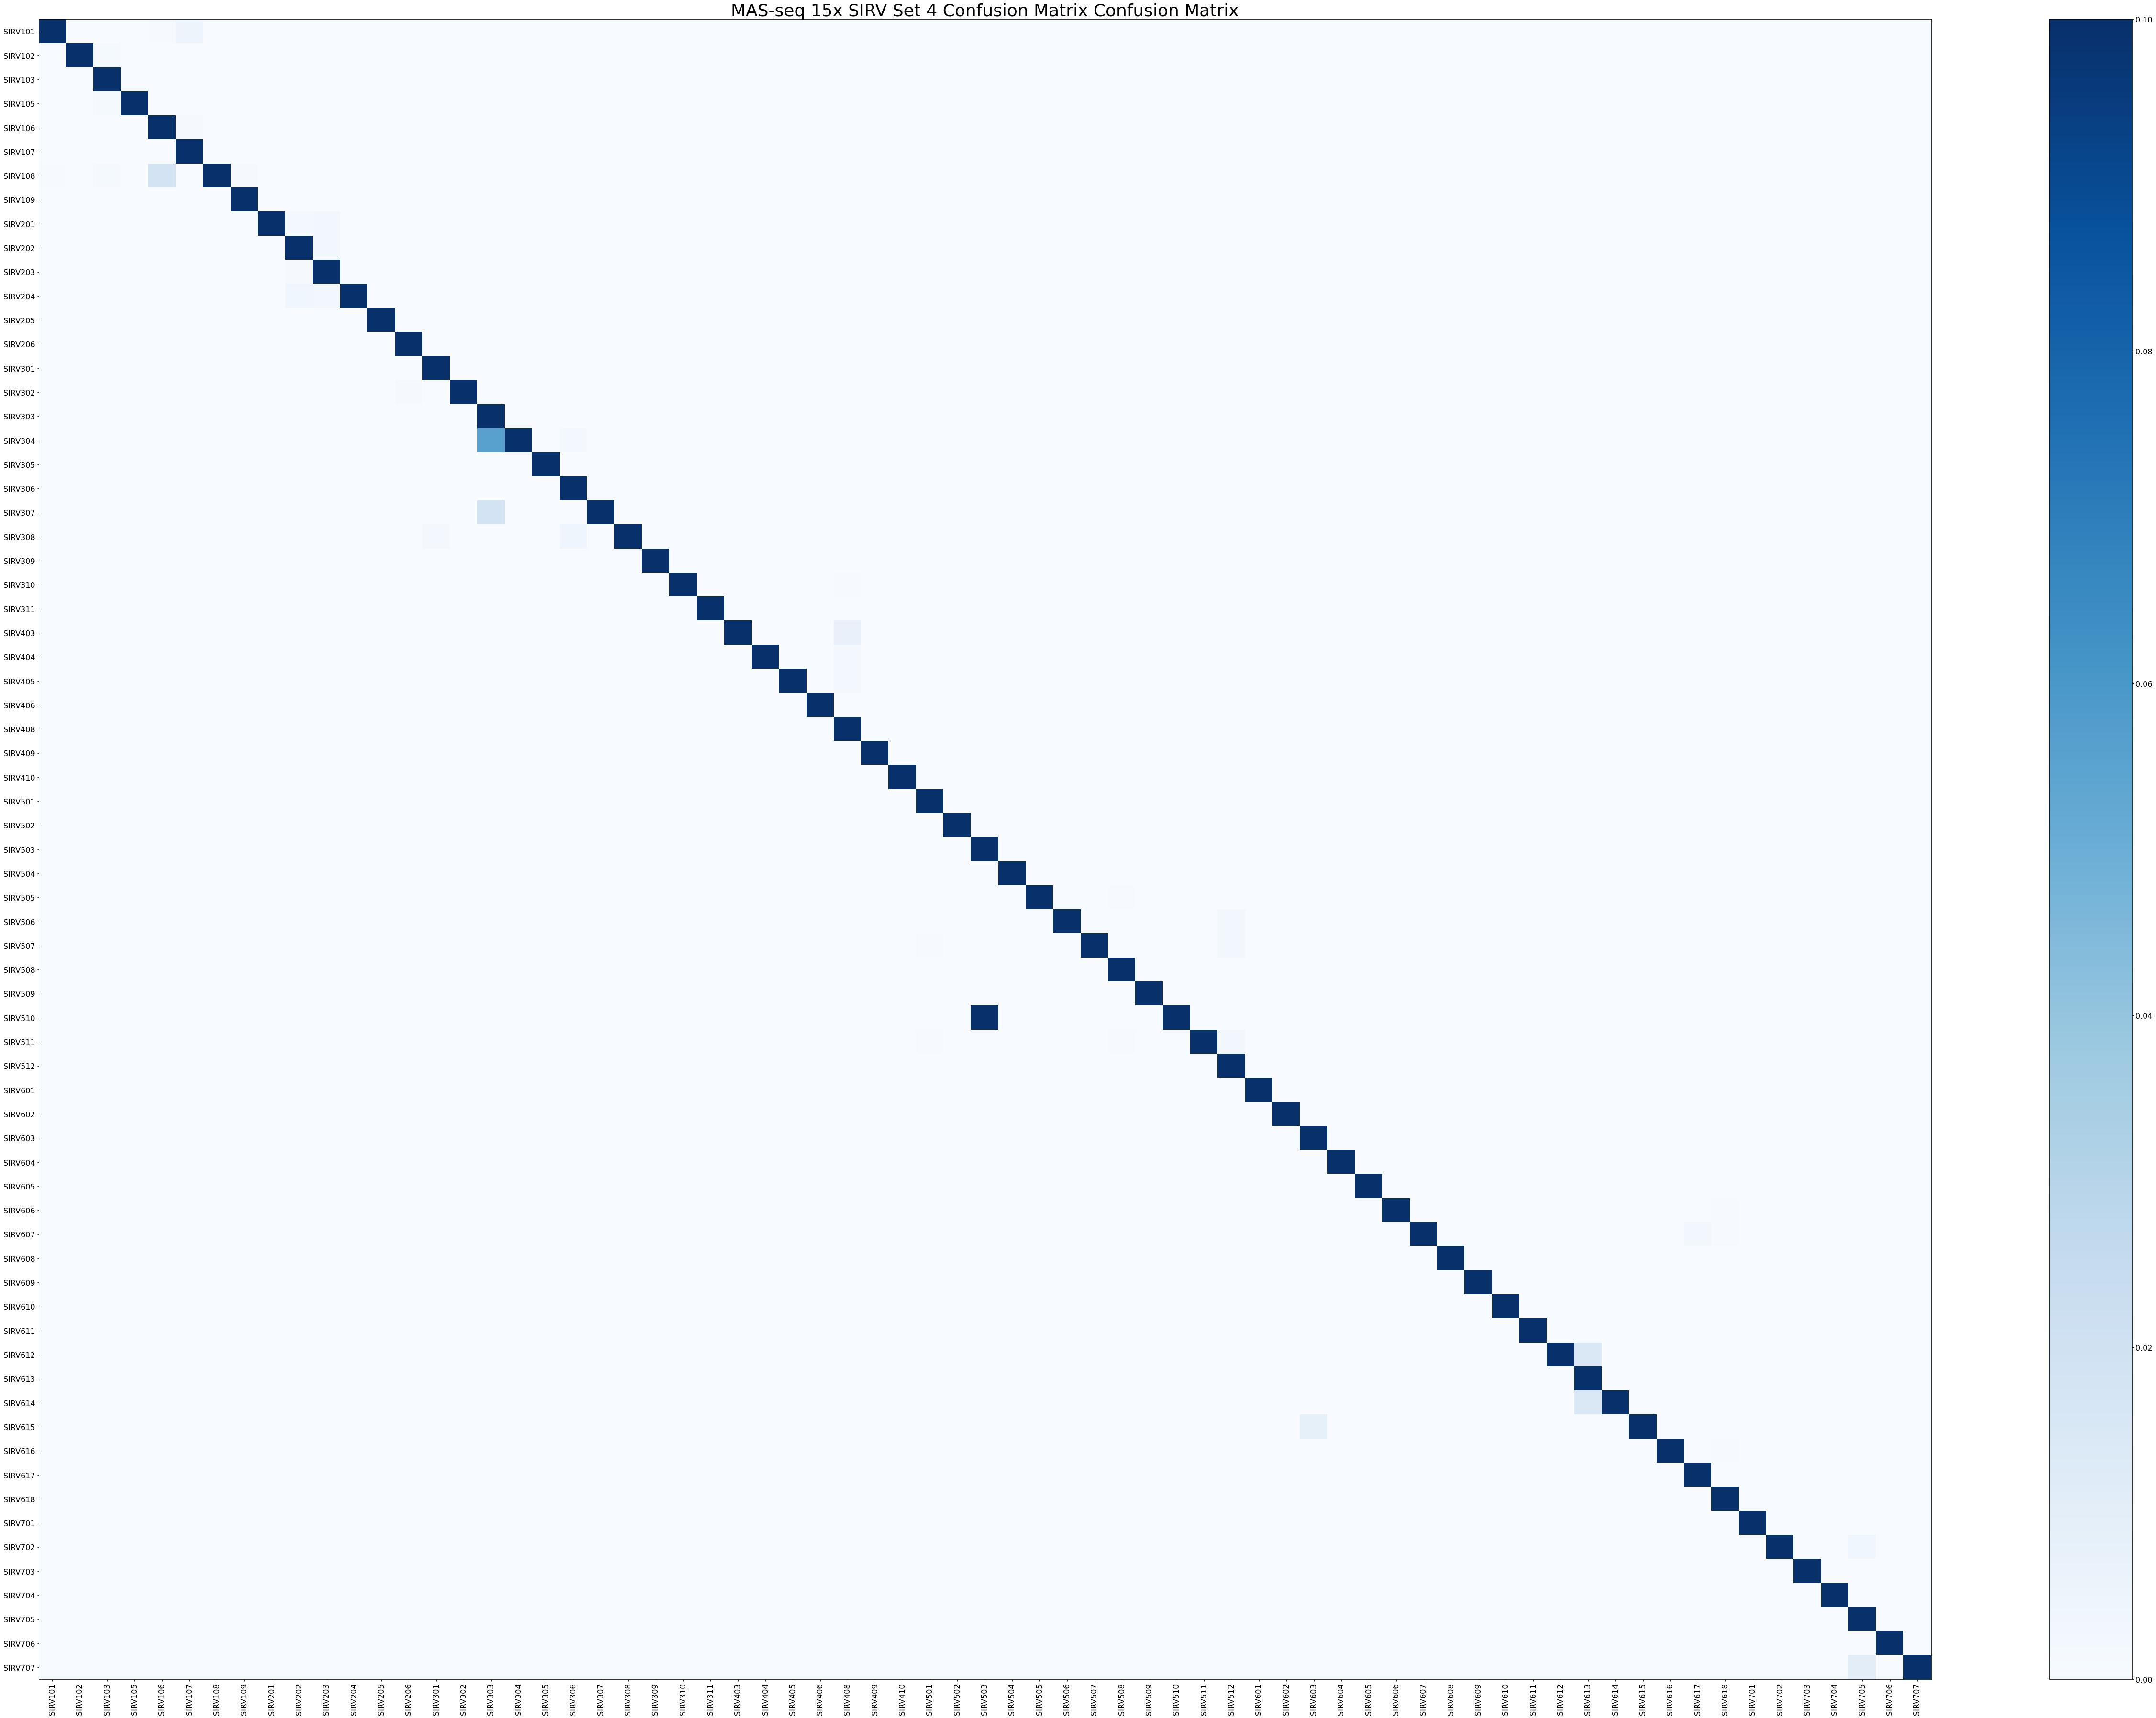

In [11]:
# MAS Seq 15x SIRVs :
mas15_sirv_sample_bam = "/home/jovyan/work/juffowup/covid-19-aziz/SIRV_Data/CDH222_SIRV_MAS_15_array_elements_longbow_extracted_tx_aligned.bam"

mas15_sirv_conf_mat_df = create_confusion_matrix(mas15_sirv_sample_bam, sirv_name_map, in_silico_sirv_set=in_silico_exclusion_set) 
si_sirv_indx = np.isin(mas15_sirv_conf_mat_df.index.values, list(real_sirv_isoform_list))
plot_confusion_matrix(mas15_sirv_conf_mat_df, si_sirv_indx, dataset_name="MAS-seq 15x SIRV Set 4 Confusion Matrix", vmax=VMAX)

save_figure("1Fb1_MAS-seq_15x_SIRV_Confusion_Matrix")

sirv_gene_score_dict = get_conf_mat_scores(mas15_sirv_conf_mat_df, si_sirv_indx)
print()
print(f"MAS-seq 15x Scores:")
for k, v in sirv_gene_score_dict.items():
    print(f"{k}\t{v}")
    
# We're going to need to clean up some memory here:
del mas15_sirv_conf_mat_df, si_sirv_indx

Creating confusion matrix from file: /home/jovyan/work/juffowup/covid-19-aziz/SIRV_Data/CDH222_SIRV_MAS_10_array_elements_longbow_extracted_tx_aligned.bam
Loading confusion matrix from Pickle (/home/jovyan/work/juffowup/covid-19-aziz/metrics2/CDH222_SIRV_MAS_10_array_elements_longbow_extracted_tx_aligned.confusion_matrix.pickle)...
Done!

MAS-seq 10x Scores:
Overall	0.9979540585510576
SIRV1	0.993456563818663
SIRV2	0.9979278802038029
SIRV3	0.997678172901696
SIRV4	0.9986919606101637
SIRV5	0.9981499450763275
SIRV6	0.9988693242065101
SIRV7	0.9999425241953916


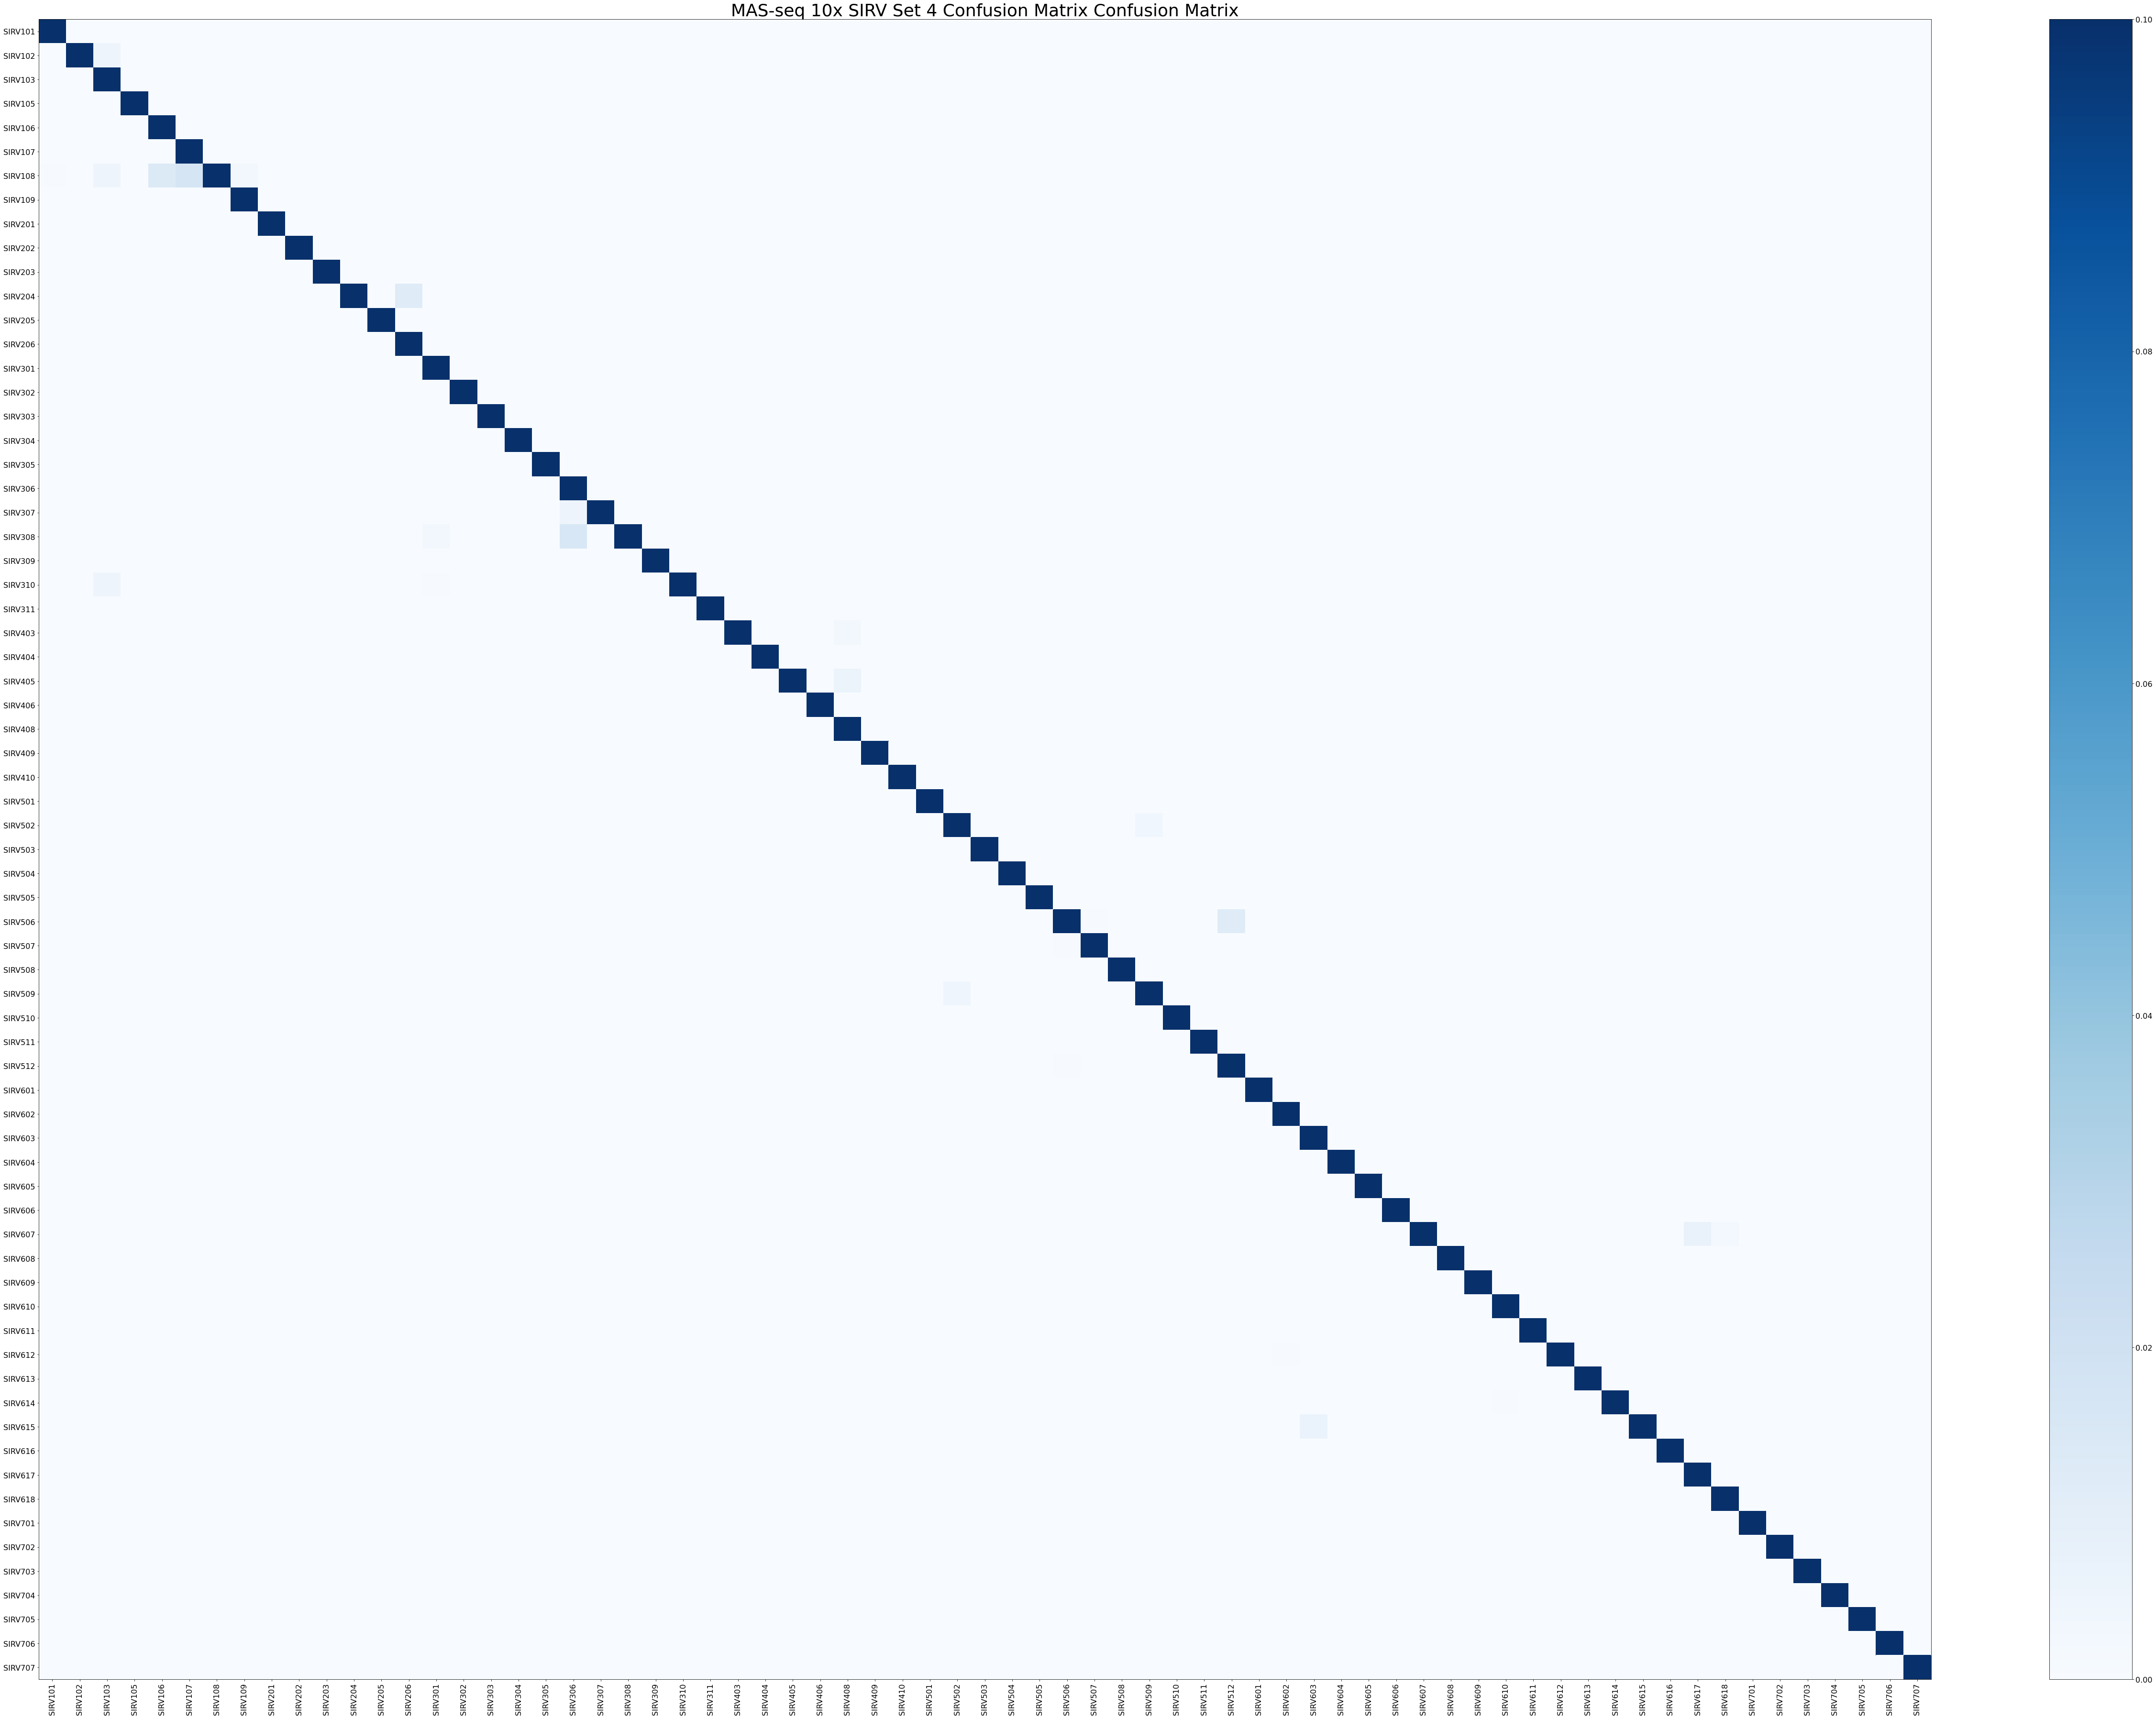

In [12]:
# MAS Seq 10x SIRVs:
mas10_sirv_sample_bam = "/home/jovyan/work/juffowup/covid-19-aziz/SIRV_Data/CDH222_SIRV_MAS_10_array_elements_longbow_extracted_tx_aligned.bam"

mas10_sirv_conf_mat_df = create_confusion_matrix(mas10_sirv_sample_bam, sirv_name_map, in_silico_sirv_set=in_silico_exclusion_set) 
si_sirv_indx = np.isin(mas10_sirv_conf_mat_df.index.values, list(real_sirv_isoform_list))
plot_confusion_matrix(mas10_sirv_conf_mat_df, si_sirv_indx, dataset_name="MAS-seq 10x SIRV Set 4 Confusion Matrix", vmax=VMAX)

save_figure("1Fb2_MAS-seq_10x_SIRV_Confusion_Matrix")

sirv_gene_score_dict = get_conf_mat_scores(mas10_sirv_conf_mat_df, si_sirv_indx)
print()
print(f"MAS-seq 10x Scores:")
for k, v in sirv_gene_score_dict.items():
    print(f"{k}\t{v}")
    
# We're going to need to clean up some memory here:
del mas10_sirv_conf_mat_df, si_sirv_indx

Creating confusion matrix from file: /home/jovyan/work/juffowup/covid-19-aziz/SIRV_Data/CDH222_SIRV_MAS_Combined_array_elements_longbow_extracted_tx_aligned.bam
Loading confusion matrix from Pickle (/home/jovyan/work/juffowup/covid-19-aziz/metrics2/CDH222_SIRV_MAS_Combined_array_elements_longbow_extracted_tx_aligned.confusion_matrix.pickle)...
Done!

MAS-seq Combined Scores:
Overall	0.9962684949197104
SIRV1	0.9950969859100904
SIRV2	0.9972328710378738
SIRV3	0.9931285906111887
SIRV4	0.9981619518188327
SIRV5	0.994931151538278
SIRV6	0.9977354693107874
SIRV7	0.9979742415160123


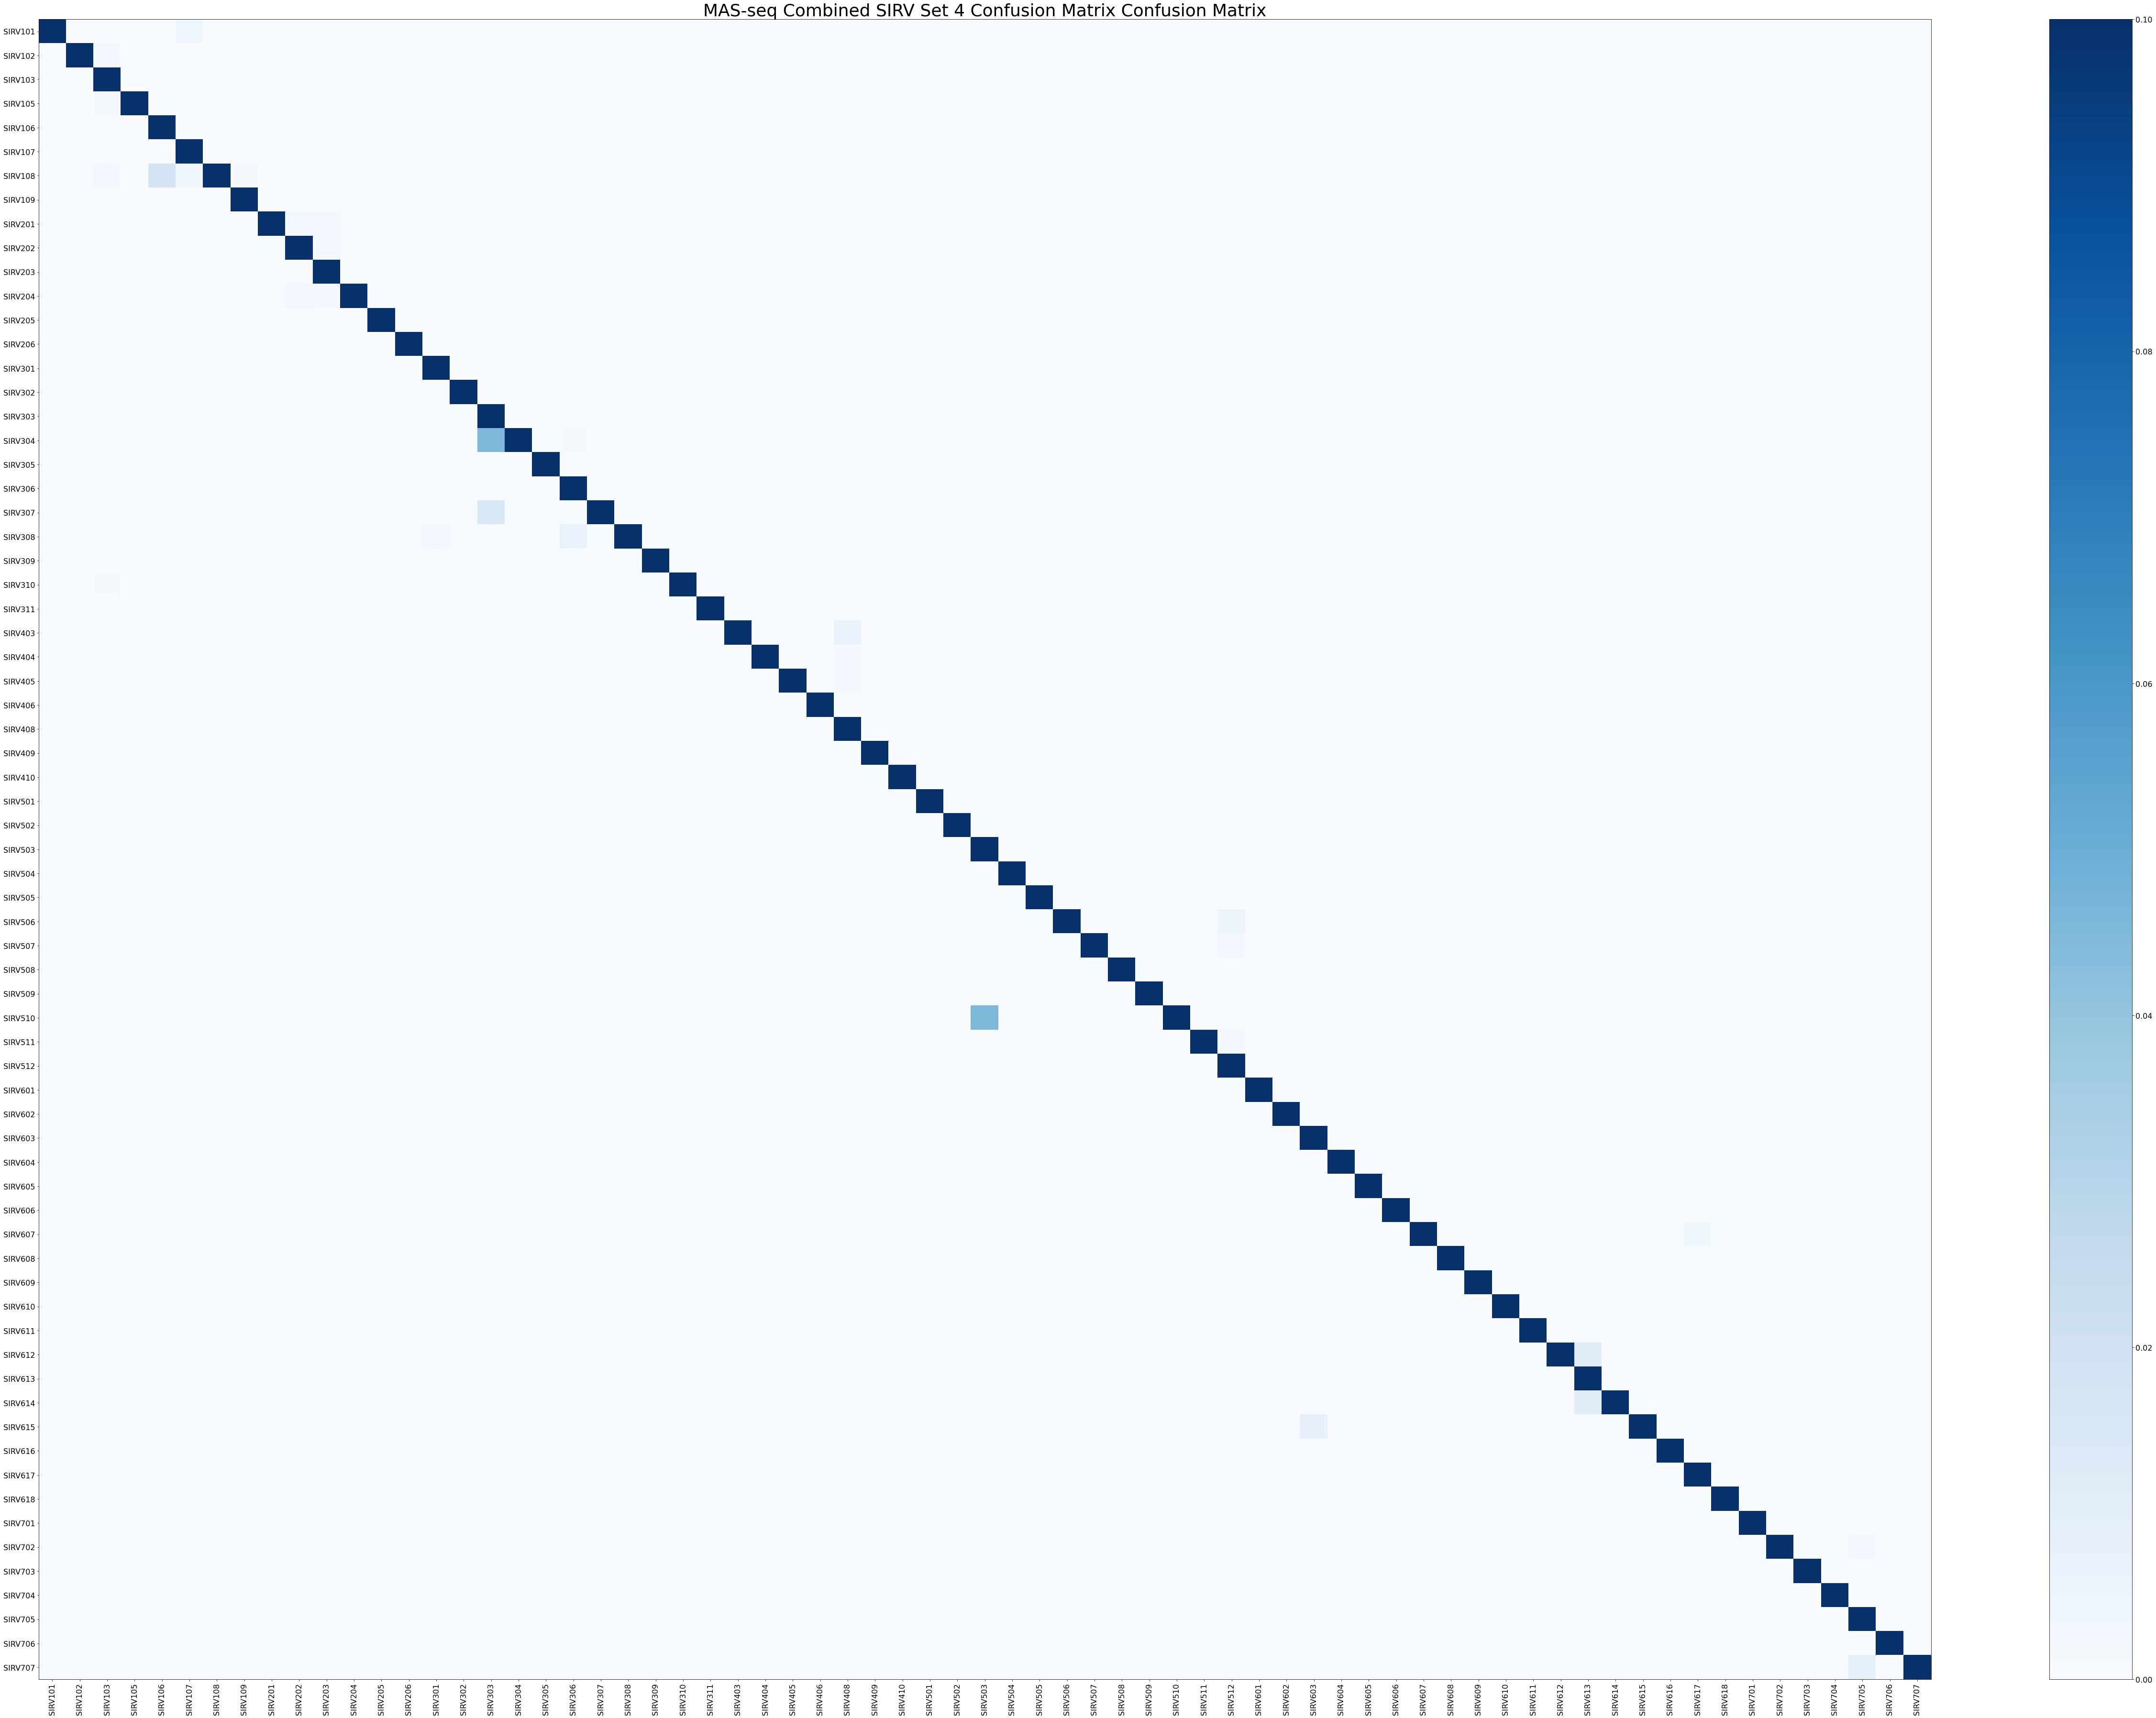

In [13]:
# MAS Seq Combined SIRVs:
mas_sirv_sample_bam = "/home/jovyan/work/juffowup/covid-19-aziz/SIRV_Data/CDH222_SIRV_MAS_Combined_array_elements_longbow_extracted_tx_aligned.bam"

mas_sirv_conf_mat_df = create_confusion_matrix(mas_sirv_sample_bam, sirv_name_map, in_silico_sirv_set=in_silico_exclusion_set) 
si_sirv_indx = np.isin(mas_sirv_conf_mat_df.index.values, list(real_sirv_isoform_list))
plot_confusion_matrix(mas_sirv_conf_mat_df, si_sirv_indx, dataset_name="MAS-seq Combined SIRV Set 4 Confusion Matrix", vmax=VMAX)

save_figure("1Fb_MAS-seq_combined_SIRV_Confusion_Matrix")

sirv_gene_score_dict = get_conf_mat_scores(mas_sirv_conf_mat_df, si_sirv_indx)
print()
print(f"MAS-seq Combined Scores:")
for k, v in sirv_gene_score_dict.items():
    print(f"{k}\t{v}")

# We're going to need to clean up some memory here:
del mas_sirv_conf_mat_df, si_sirv_indx


SmartSeq3 Combined Scores:
Overall	0.5680723477221904
SIRV1	0.5649964102703267
SIRV2	0.4322743846944927
SIRV3	0.4308459484357679
SIRV4	0.7034832407421462
SIRV5	0.6647131043090738
SIRV6	0.6244334189429674
SIRV7	0.4232484979146251


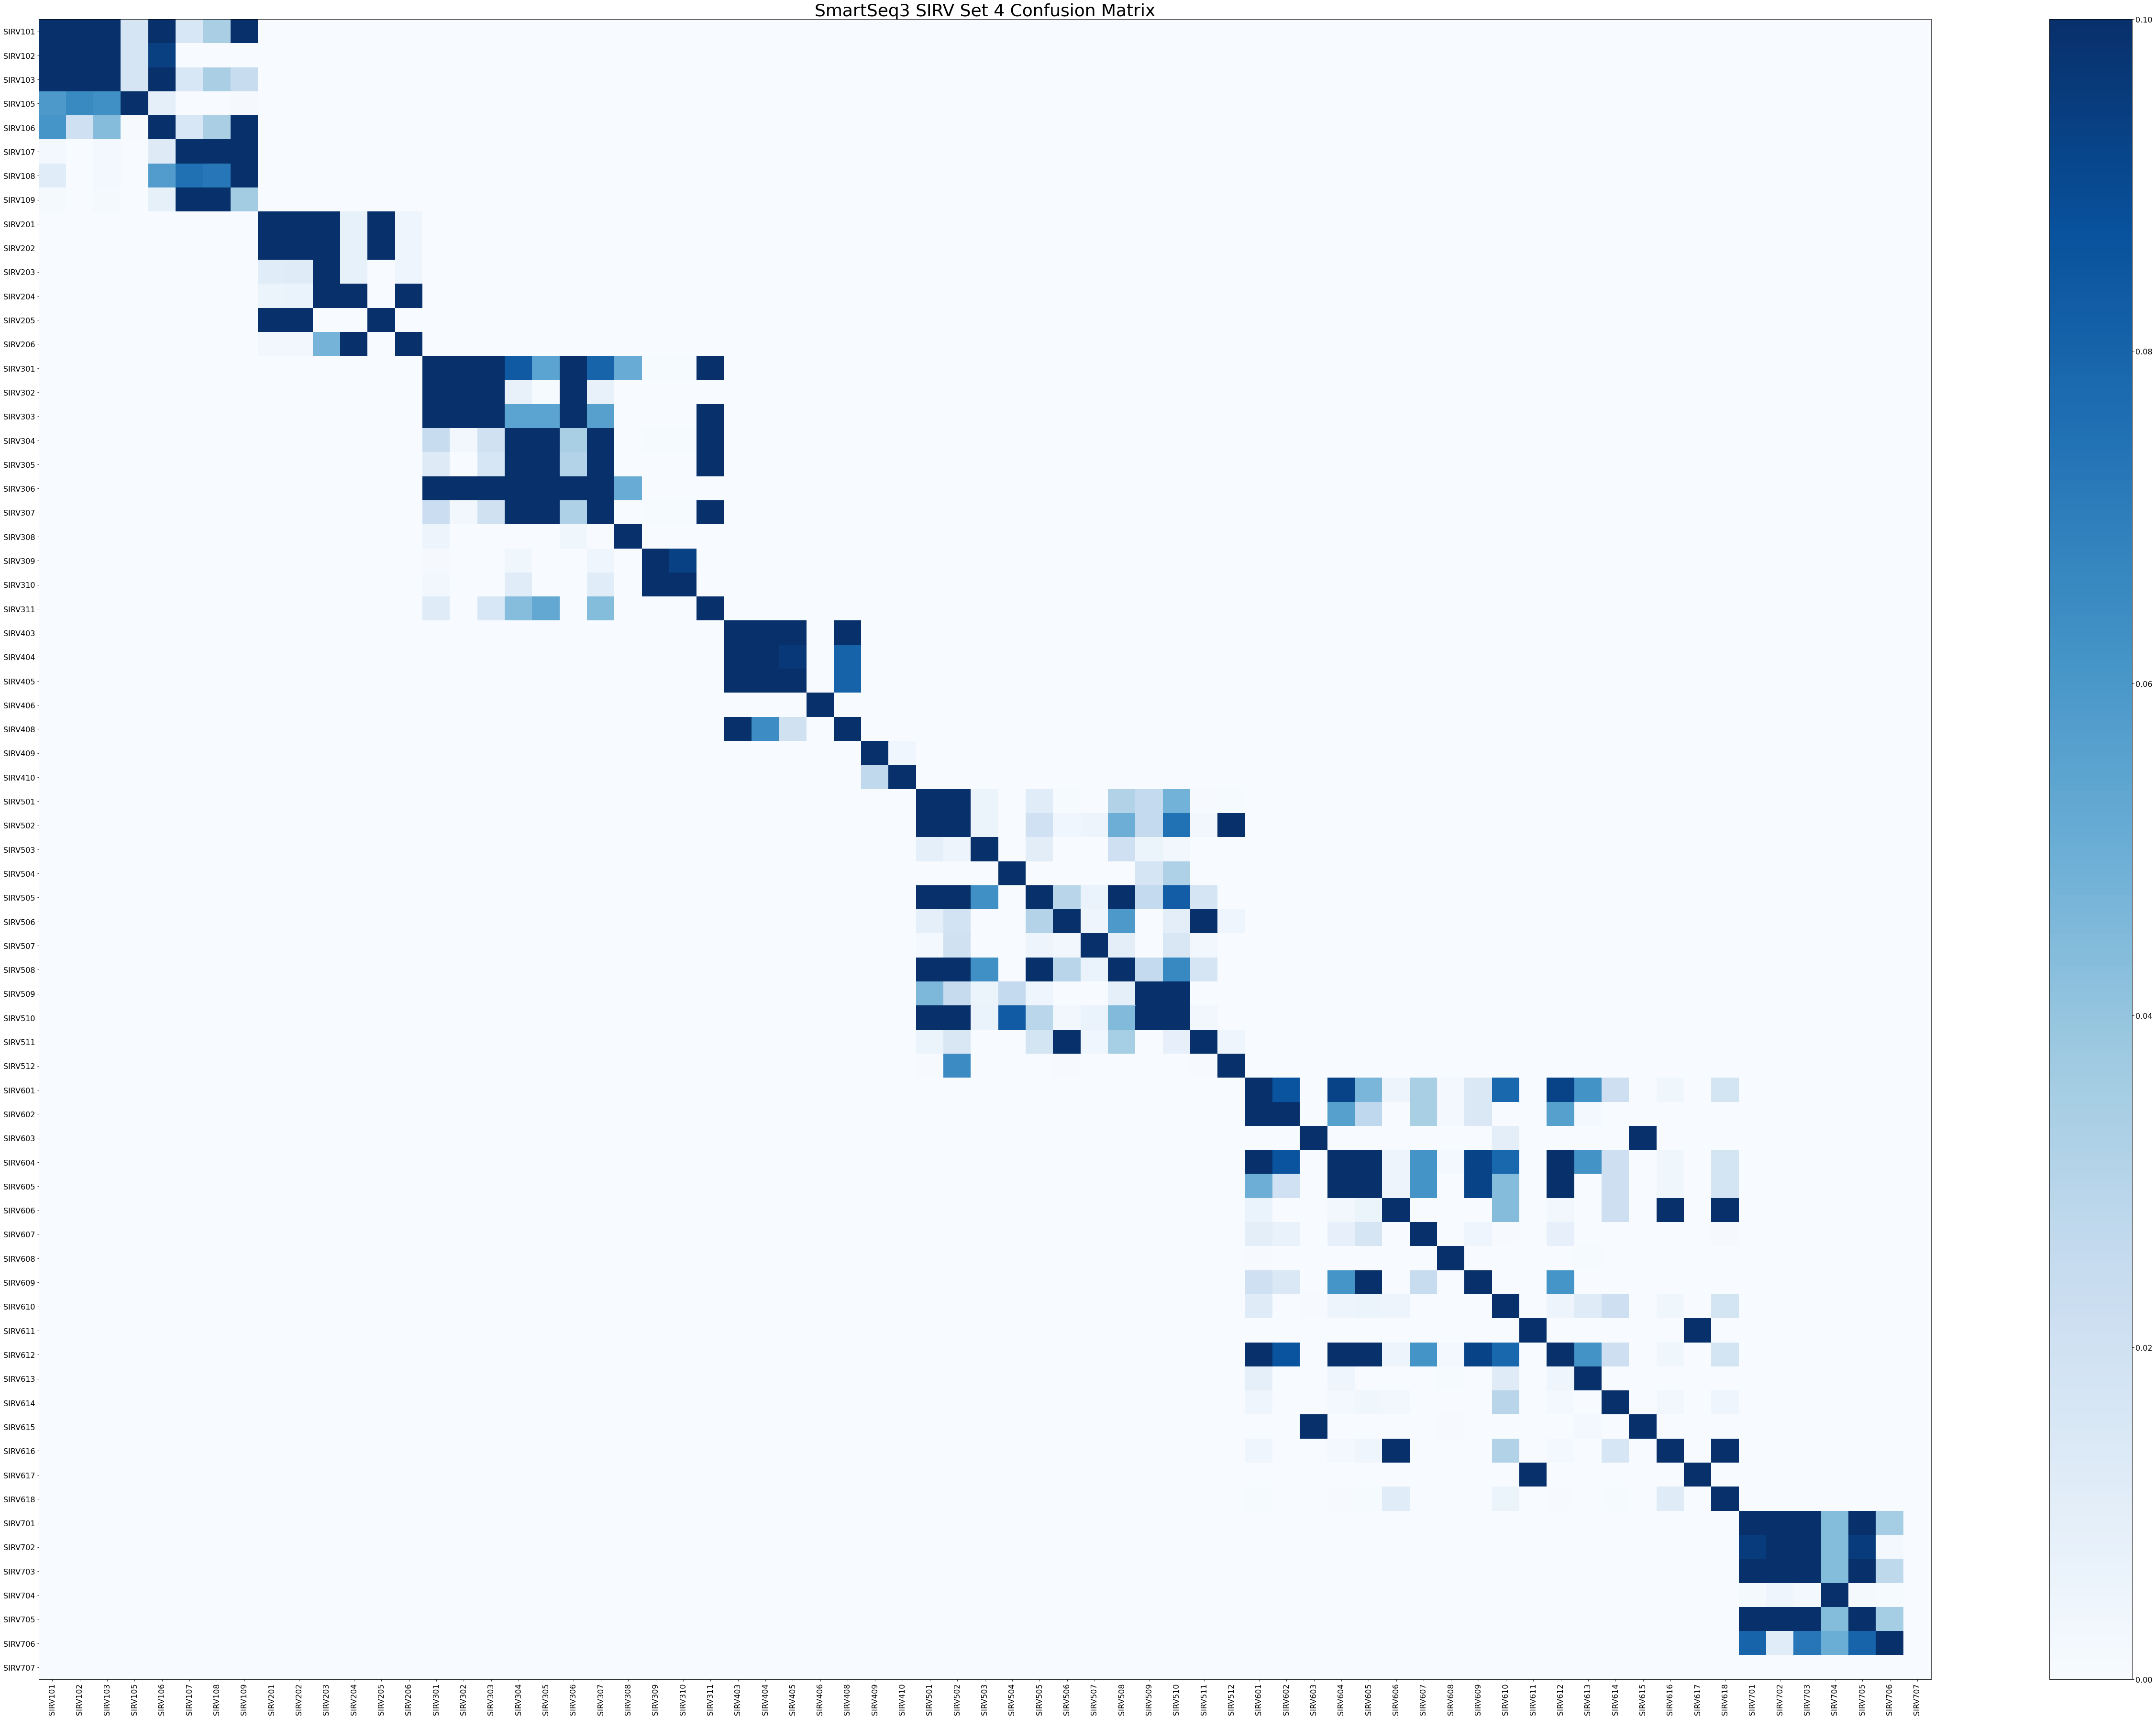

In [14]:
# Load in SS3 data and adjust to our rows / cols:
ss3_count_matrix = np.load("/home/jovyan/work/juffowup/covid-19-aziz/SIRV_Data/SS3/ss3_confusion_matrix_tt.npy")
ss3_sirv_names = []
with open("/home/jovyan/work/juffowup/covid-19-aziz/SIRV_Data/SS3/ss3_confusion_matrix_transcript_ids.txt", "r") as f:
    for l in f:
        ss3_sirv_names.append(l.strip())

ss3_adjusted_count_matrix = np.zeros((len(sirv_set_4_names), len(sirv_set_4_names)), dtype=np.float)
for i, sn_i in enumerate(ss3_sirv_names):
    for j, sn_j in enumerate(ss3_sirv_names):
        s1_i = sirv_mat_index_dict[sn_i]
        s2_i = sirv_mat_index_dict[sn_j]
        ss3_adjusted_count_matrix[s1_i][s2_i] = ss3_count_matrix[i][j]
        
ss3_adjusted_count_matrix_df = pd.DataFrame(data=ss3_adjusted_count_matrix, index=sirv_mat_index_dict.keys(), columns=sirv_mat_index_dict.keys())

si_sirv_indx = np.isin(ss3_adjusted_count_matrix_df.index.values, list(real_sirv_isoform_list))

fig = plt.figure(figsize=[i*5 for i in gFIG_SIZE_in])
ax = fig.add_subplot()

plt.pcolor(ss3_adjusted_count_matrix_df[real_sirv_isoform_list][si_sirv_indx], cmap=plt.get_cmap("Blues"), vmax=VMAX)

plt.yticks(ticks=np.arange(0.5, len(ss3_adjusted_count_matrix_df.index[si_sirv_indx]), 1), labels=ss3_adjusted_count_matrix_df.index[si_sirv_indx])
plt.xticks(ticks=np.arange(0.5, len(ss3_adjusted_count_matrix_df.columns[si_sirv_indx]), 1), labels=ss3_adjusted_count_matrix_df.columns[si_sirv_indx])
ax.set_xticklabels(ss3_adjusted_count_matrix_df.columns[si_sirv_indx], rotation=90)
plt.gca().invert_yaxis()  # Make it like Mehrtash's plot
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
ax.set_title(f'SmartSeq3 SIRV Set 4 Confusion Matrix');
fix_matplotlib_plot_visuals(fig, gTITLE_FONT_SIZE, gTITLE_FONT_SIZE, gTICK_LABEL_FONT_SIZE)
fig.show()

save_figure("1Fc_SmartSeq3_SIRV_Confusion_Matrix")

sirv_gene_score_dict = get_conf_mat_scores(ss3_adjusted_count_matrix_df, si_sirv_indx)
print()
print(f"SmartSeq3 Combined Scores:")
for k, v in sirv_gene_score_dict.items():
    print(f"{k}\t{v}")

***

Creating confusion matrix from file: /home/jovyan/work/juffowup/covid-19-aziz/SIRV_Data/FIXED/CDH222_SIRV_MAS_15_array_elements_longbow_extracted_tx_aligned.FIXED.bam
Loading confusion matrix from Pickle (/home/jovyan/work/juffowup/covid-19-aziz/metrics2/CDH222_SIRV_MAS_15_array_elements_longbow_extracted_tx_aligned.FIXED.confusion_matrix.pickle)...
Done!

MAS-seq MAS-15 FIXED Scores:
Overall	0.9981331722042607
SIRV1	0.9960076838725522
SIRV2	0.9966189306219254
SIRV3	0.9950716723744133
SIRV4	0.999988859227637
SIRV5	0.9985285485850902
SIRV6	0.9996788943307208
SIRV7	0.999946986073621


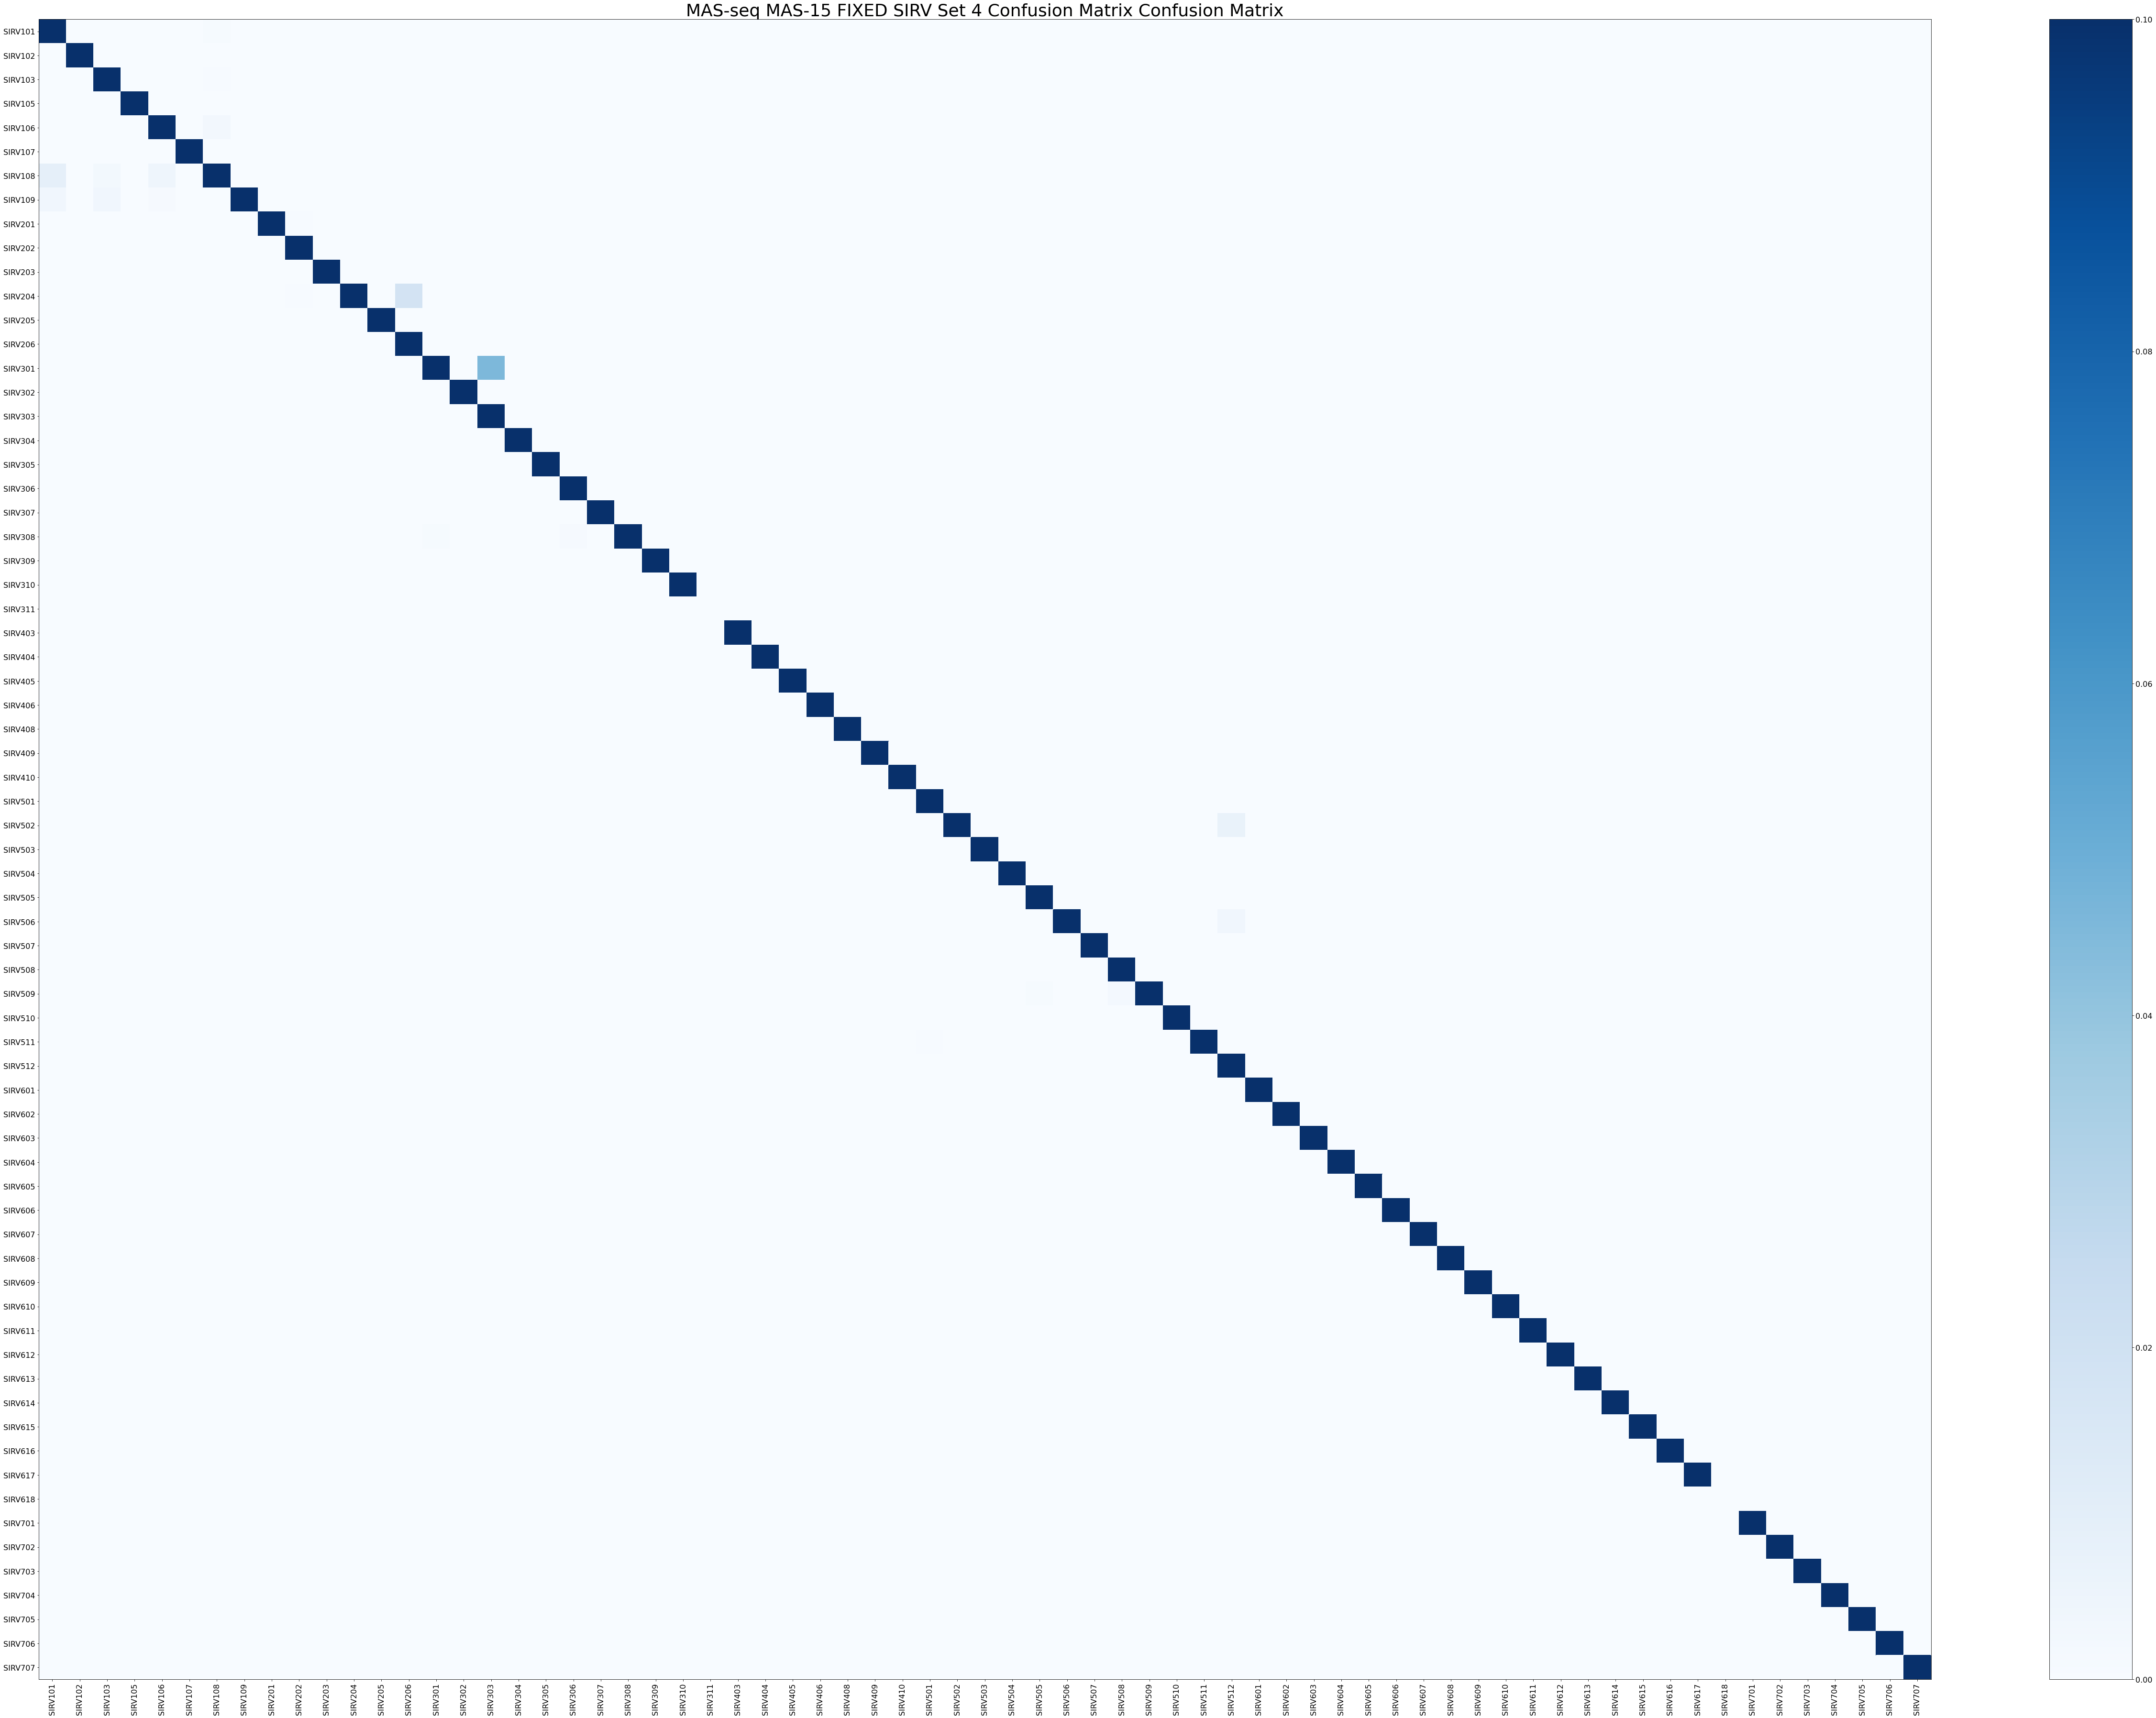

In [19]:
# Fixed MAS-15:
mas_sirv_sample_bam = "/home/jovyan/work/juffowup/covid-19-aziz/SIRV_Data/FIXED/CDH222_SIRV_MAS_15_array_elements_longbow_extracted_tx_aligned.FIXED.bam"

mas_sirv_conf_mat_df = create_confusion_matrix(mas_sirv_sample_bam, sirv_name_map, in_silico_sirv_set=in_silico_exclusion_set) 
si_sirv_indx = np.isin(mas_sirv_conf_mat_df.index.values, list(real_sirv_isoform_list))
plot_confusion_matrix(mas_sirv_conf_mat_df, si_sirv_indx, dataset_name="MAS-seq MAS-15 FIXED SIRV Set 4 Confusion Matrix", vmax=VMAX)

save_figure("1Fb1_MAS-seq_15x_FIXED_SIRV_Confusion_Matrix")

sirv_gene_score_dict = get_conf_mat_scores(mas_sirv_conf_mat_df, si_sirv_indx)
print()
print(f"MAS-seq MAS-15 FIXED Scores:")
for k, v in sirv_gene_score_dict.items():
    print(f"{k}\t{v}")

# We're going to need to clean up some memory here:
# del mas_sirv_conf_mat_df, si_sirv_indx

Creating confusion matrix from file: /home/jovyan/work/juffowup/covid-19-aziz/SIRV_Data/FIXED/CDH222_SIRV_MAS_10_array_elements_longbow_extracted_tx_aligned.FIXED.bam
Loading confusion matrix from Pickle (/home/jovyan/work/juffowup/covid-19-aziz/metrics2/CDH222_SIRV_MAS_10_array_elements_longbow_extracted_tx_aligned.FIXED.confusion_matrix.pickle)...
Done!

MAS-seq MAS-10 FIXED Scores:
Overall	0.9992679188568915
SIRV1	0.9962157302615551
SIRV2	0.9995308637843583
SIRV3	0.9995943223776229
SIRV4	0.9999801328357945
SIRV5	0.9994681115428317
SIRV6	0.9997199397440015
SIRV7	0.9999435123707672


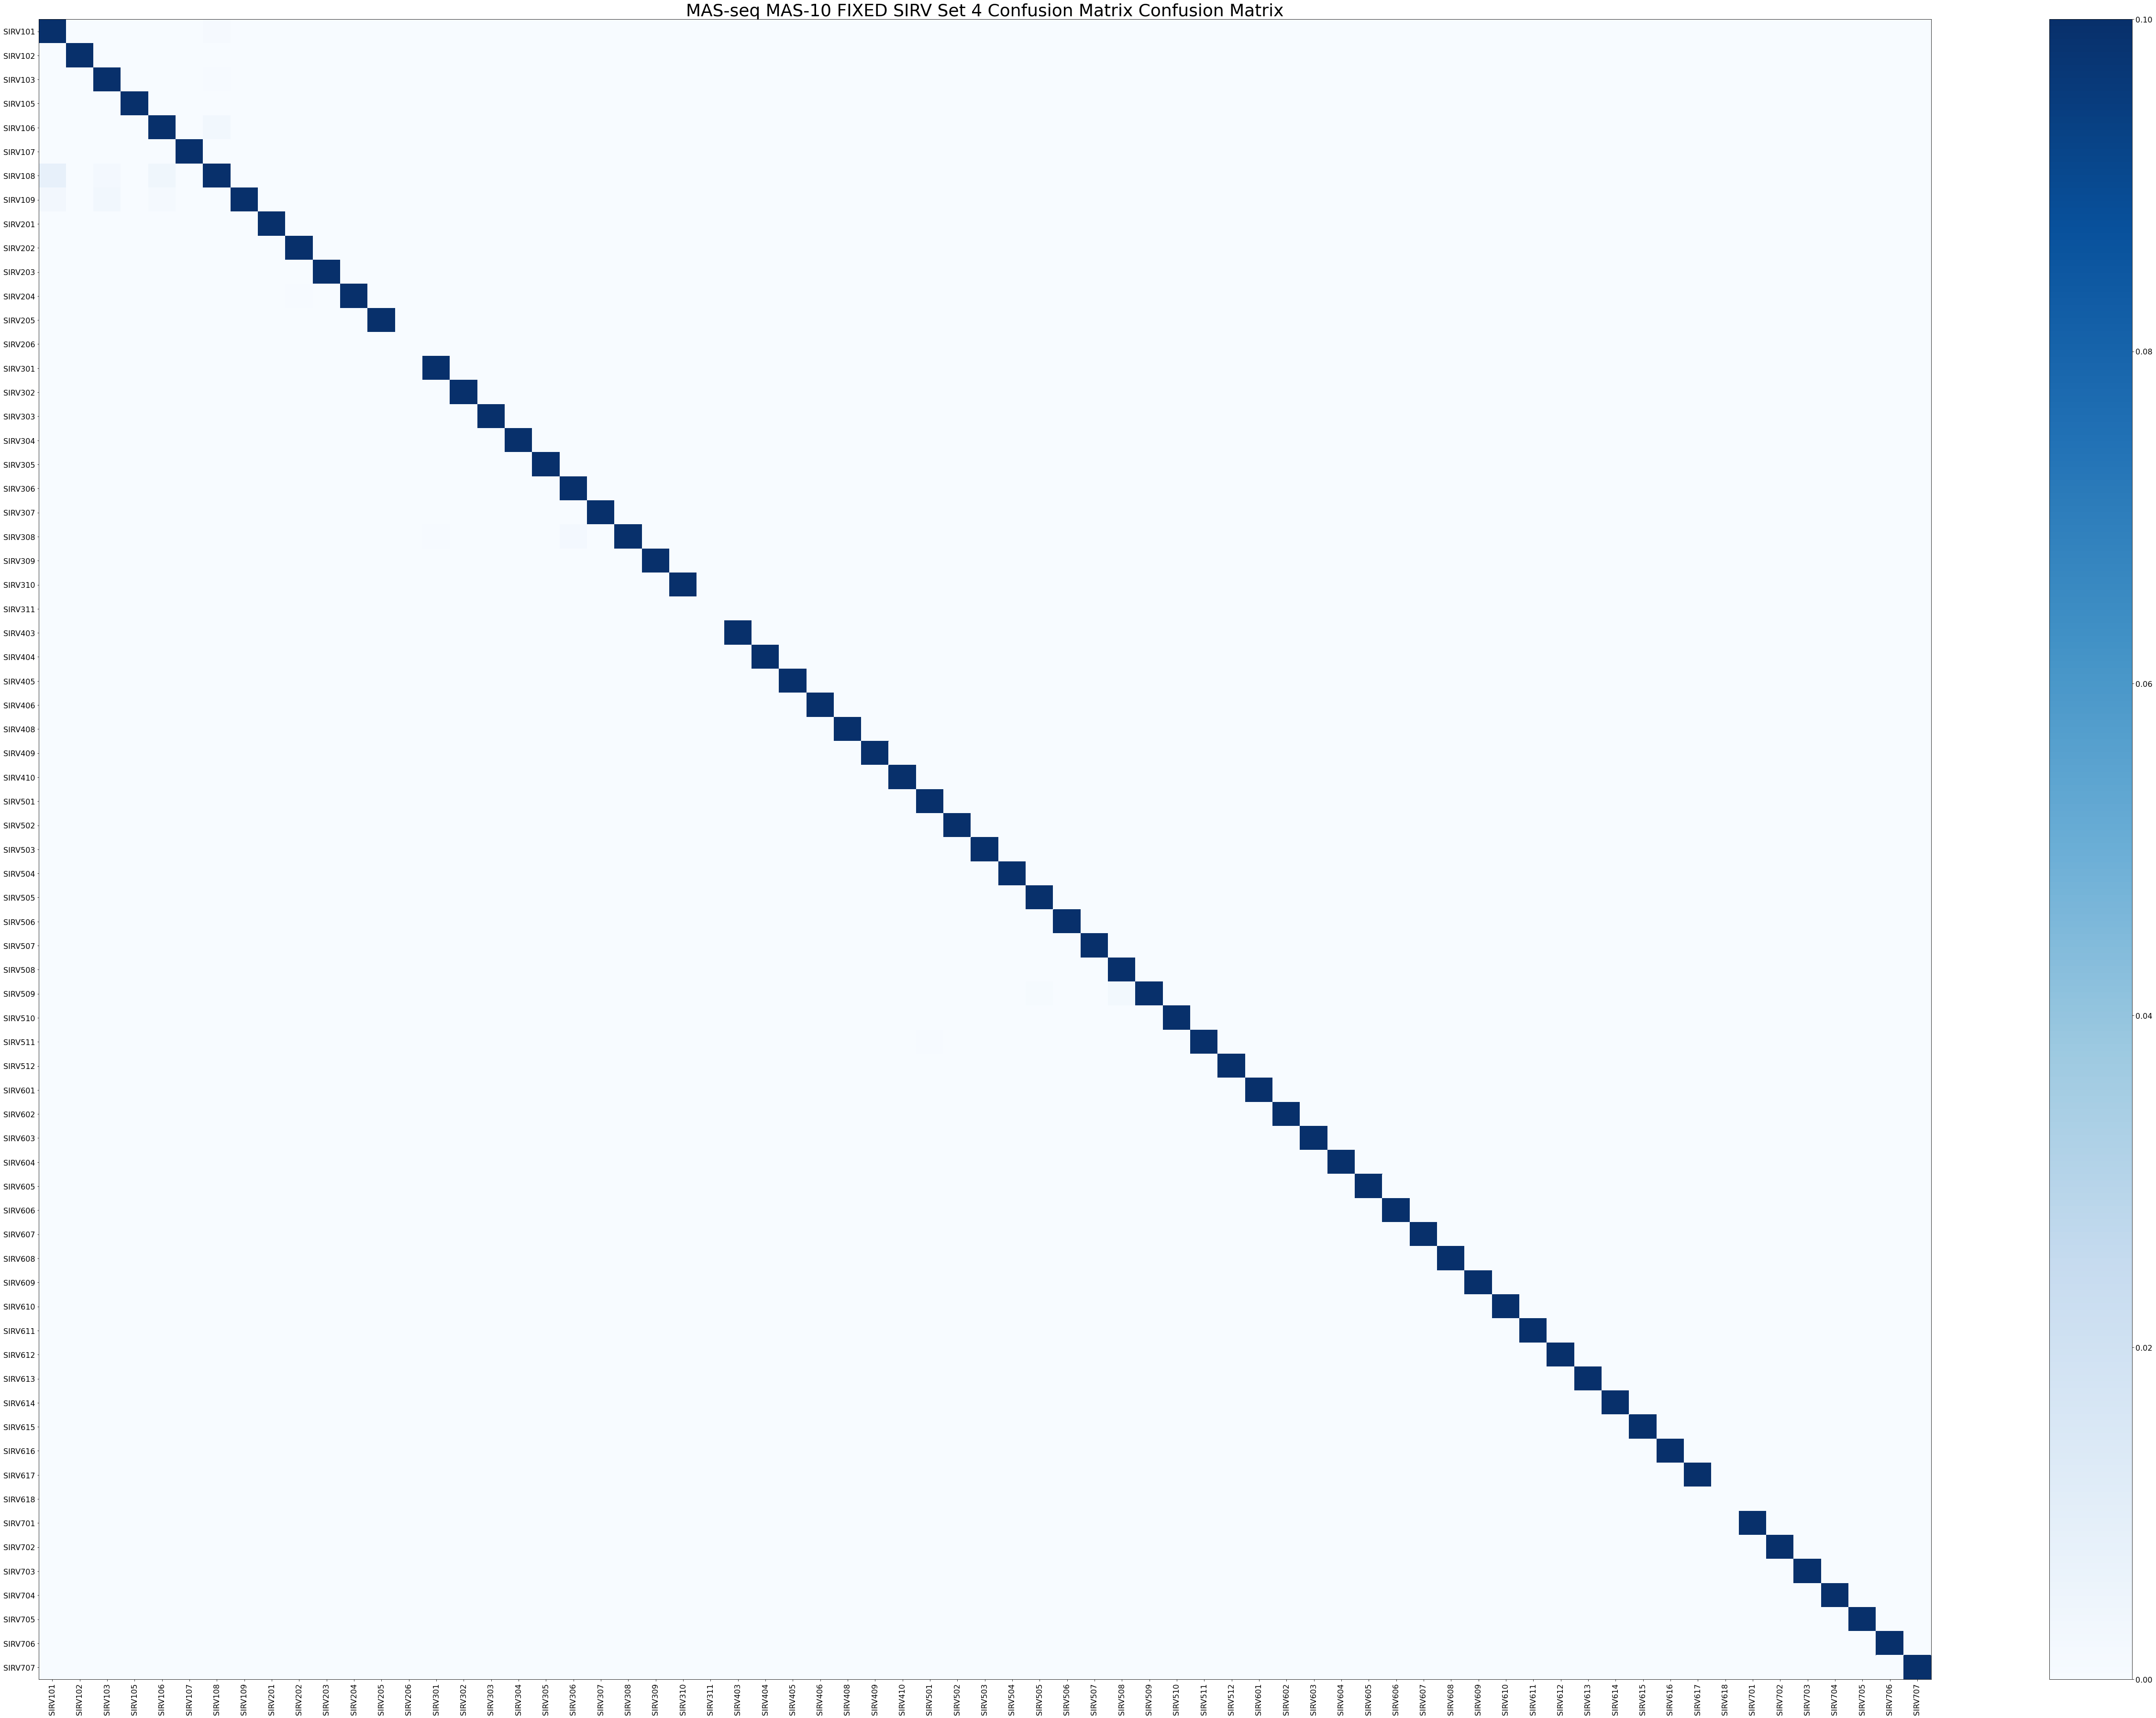

In [20]:
# Fixed MAS-10:
mas_sirv_sample_bam = "/home/jovyan/work/juffowup/covid-19-aziz/SIRV_Data/FIXED/CDH222_SIRV_MAS_10_array_elements_longbow_extracted_tx_aligned.FIXED.bam"

mas_sirv_conf_mat_df = create_confusion_matrix(mas_sirv_sample_bam, sirv_name_map, in_silico_sirv_set=in_silico_exclusion_set) 
si_sirv_indx = np.isin(mas_sirv_conf_mat_df.index.values, list(real_sirv_isoform_list))
plot_confusion_matrix(mas_sirv_conf_mat_df, si_sirv_indx, dataset_name="MAS-seq MAS-10 FIXED SIRV Set 4 Confusion Matrix", vmax=VMAX)

save_figure("1Fb1_MAS-seq_10x_FIXED_SIRV_Confusion_Matrix")

sirv_gene_score_dict = get_conf_mat_scores(mas_sirv_conf_mat_df, si_sirv_indx)
print()
print(f"MAS-seq MAS-10 FIXED Scores:")
for k, v in sirv_gene_score_dict.items():
    print(f"{k}\t{v}")
    

# We're going to need to clean up some memory here:
del mas_sirv_conf_mat_df, si_sirv_indx

In [21]:
# Fixed combined MAS SIRV library
mas_sirv_sample_bam = "/home/jovyan/work/juffowup/covid-19-aziz/SIRV_Data/FIXED/CDH222_SIRV_MAS_Combined_array_elements_longbow_extracted_tx_aligned.FIXED.bam"

mas_sirv_conf_mat_df = create_confusion_matrix(mas_sirv_sample_bam, sirv_name_map, in_silico_sirv_set=in_silico_exclusion_set) 

Creating confusion matrix from file: /home/jovyan/work/juffowup/covid-19-aziz/SIRV_Data/FIXED/CDH222_SIRV_MAS_Combined_array_elements_longbow_extracted_tx_aligned.FIXED.bam
Loading confusion matrix from Pickle (/home/jovyan/work/juffowup/covid-19-aziz/metrics2/CDH222_SIRV_MAS_Combined_array_elements_longbow_extracted_tx_aligned.FIXED.confusion_matrix.pickle)...
Done!



MAS-seq Combined FIXED Scores:
Overall	0.9983438639985108
SIRV1	0.9960461122837487
SIRV2	0.9966032069621634
SIRV3	0.9962801258734301
SIRV4	0.9999874615518106
SIRV5	0.9986706764554141
SIRV6	0.9996859193206726
SIRV7	0.9999464651535193


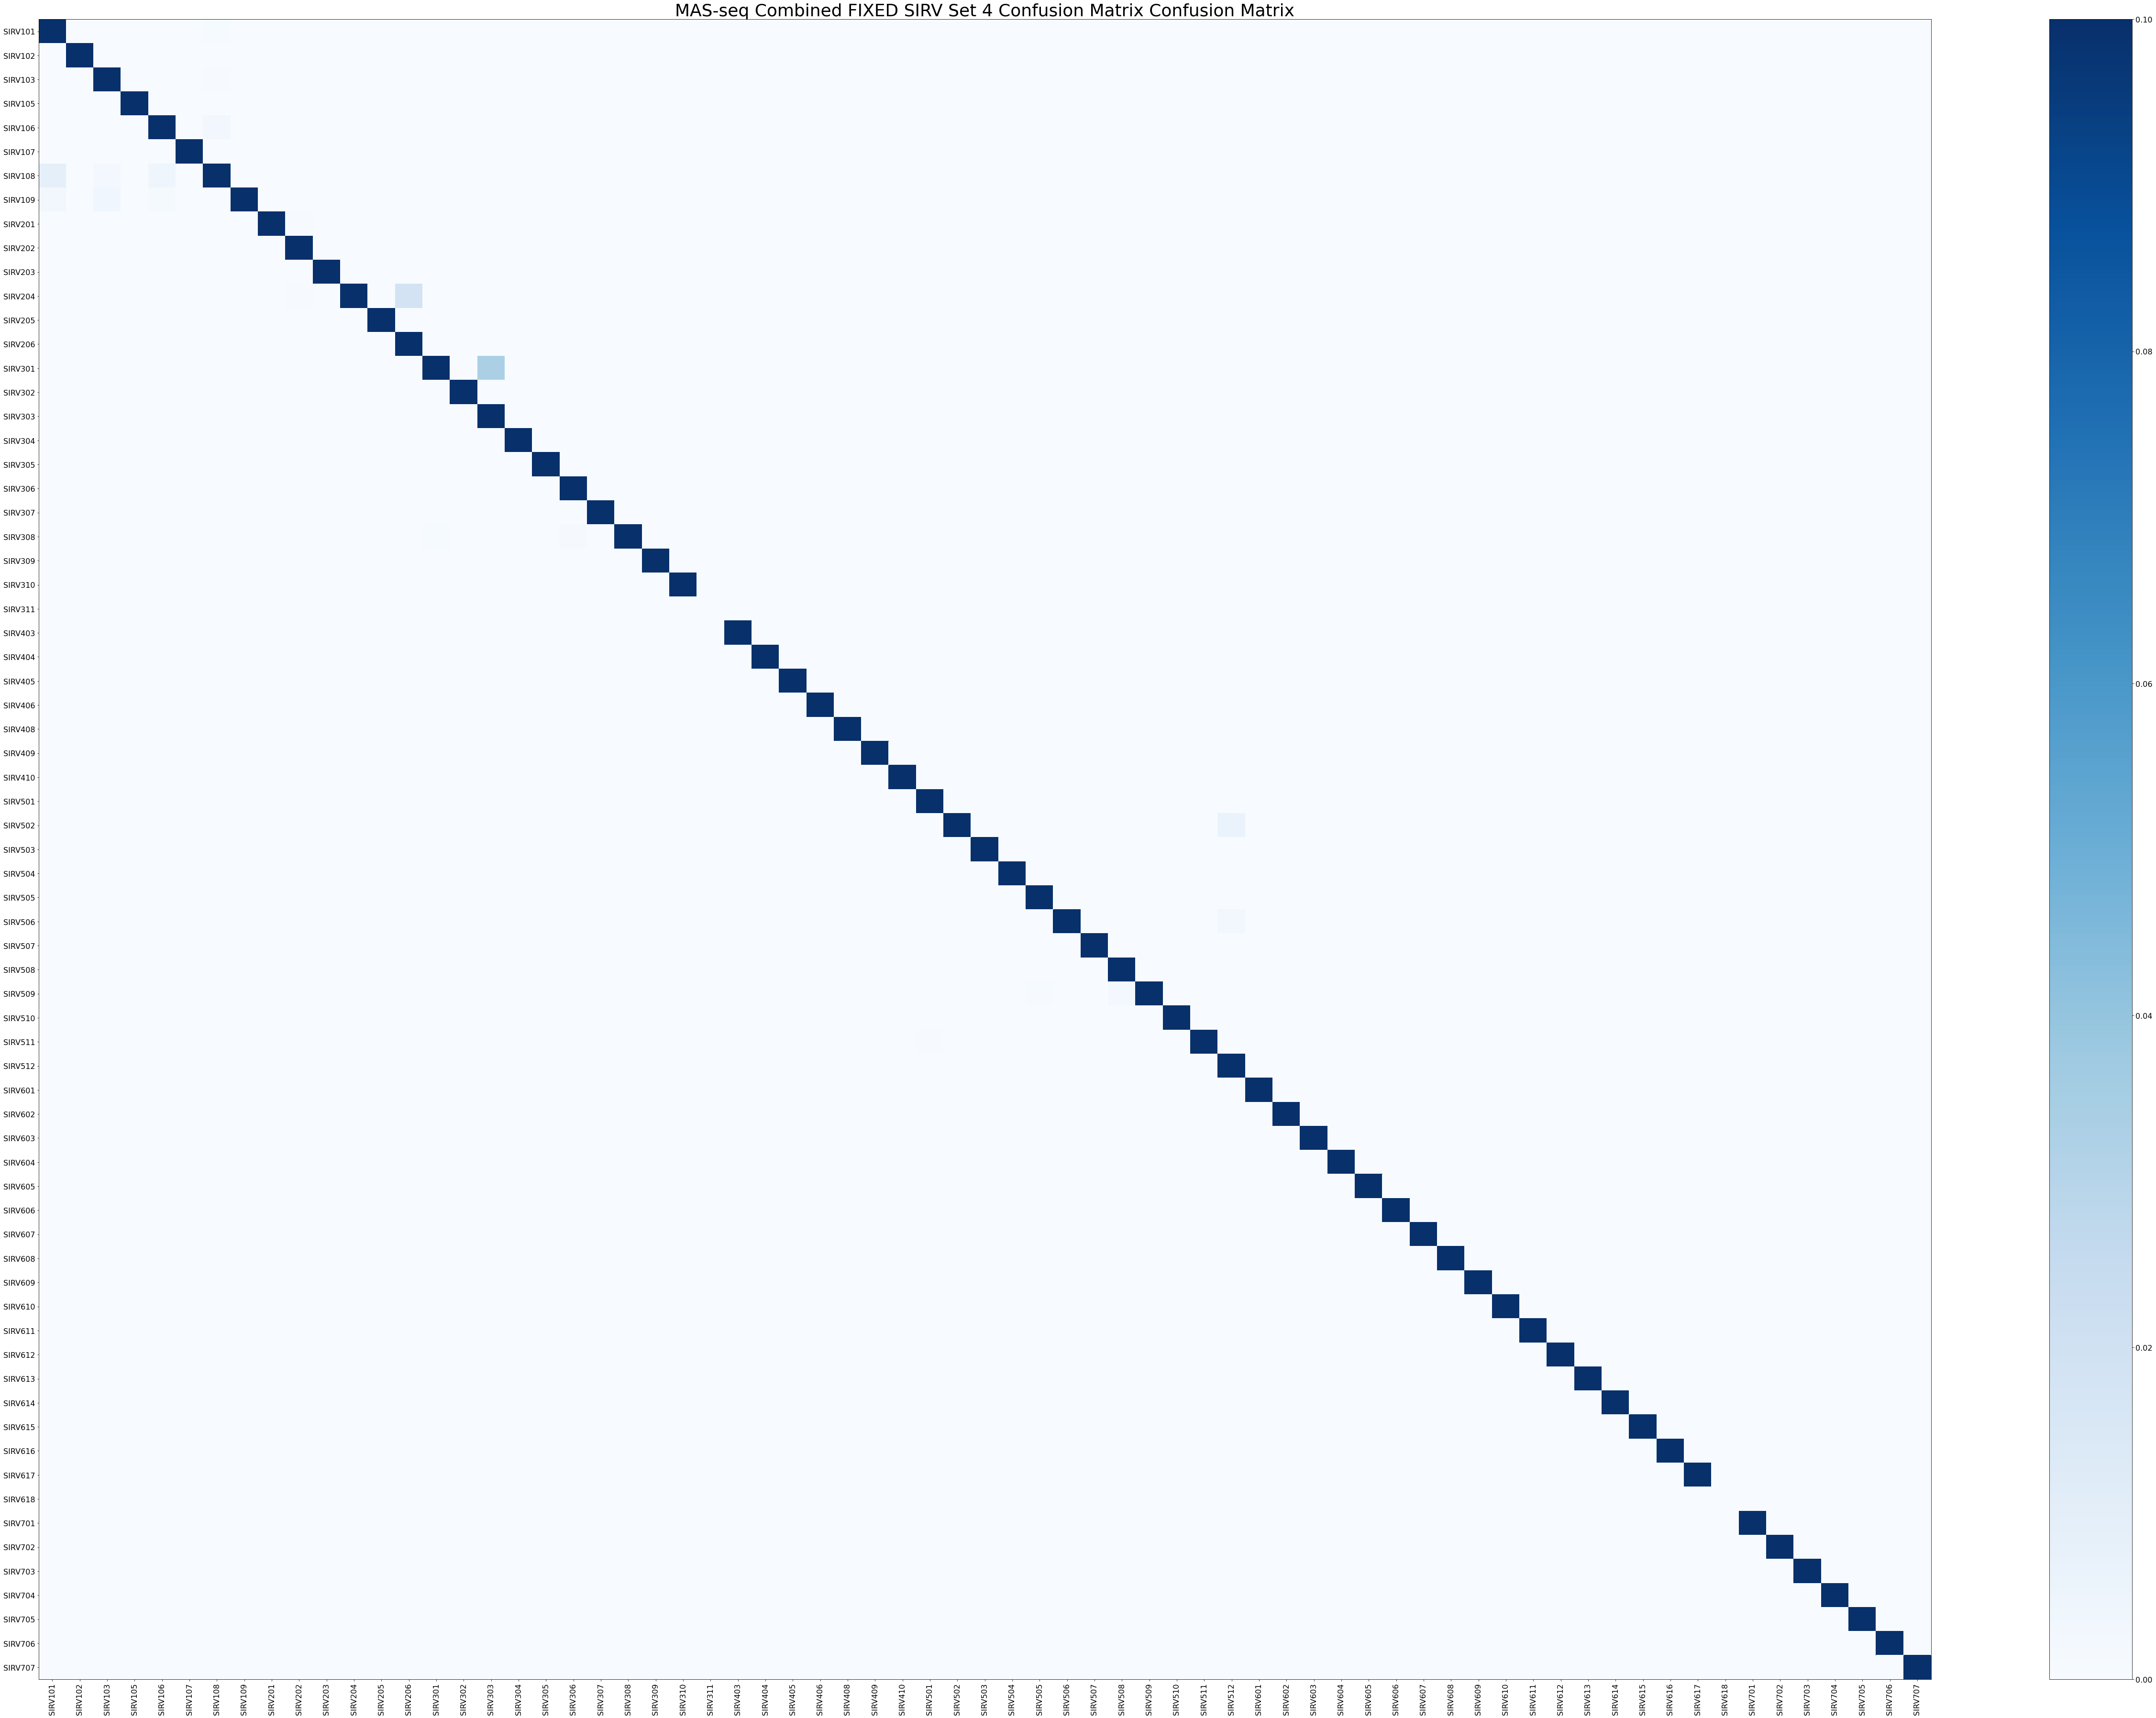

In [22]:
si_sirv_indx = np.isin(mas_sirv_conf_mat_df.index.values, list(real_sirv_isoform_list))
plot_confusion_matrix(mas_sirv_conf_mat_df, si_sirv_indx, dataset_name="MAS-seq Combined FIXED SIRV Set 4 Confusion Matrix", vmax=VMAX)

save_figure("1Fb1_MAS-seq_Combined_FIXED_SIRV_Confusion_Matrix")

sirv_gene_score_dict = get_conf_mat_scores(mas_sirv_conf_mat_df, si_sirv_indx)
print()
print(f"MAS-seq Combined FIXED Scores:")
for k, v in sirv_gene_score_dict.items():
    print(f"{k}\t{v}")

# We're going to need to clean up some memory here:
# del mas_sirv_conf_mat_df, si_sirv_indx